In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from scipy import stats
from statistics import stdev
import datetime
from datetime import timedelta
from collections import Counter
import cx_Oracle
import psycopg2
import seaborn as sns
import json
import pickle
#from fitter import Fitter
from warnings import filterwarnings
filterwarnings('ignore')

Valid orders within 6 months in ES Shop (from 01/03/2018 to 30/09/2018) with a TC mapping

### Data loading, cleaning & formatting

In [2]:
data = pd.read_csv('6_months_orders_es_shop_blacklisting_patterns.dsv', sep=';', low_memory=False)

In [3]:
data.head()

,OP_ID,O_DATE,O_ID,O_K_ID,TC_ID,OP_AS_ID,OP_AMOUNT,APS_AP_ID,OP_PRICE,O_GWERT,OSP_KO_COUNT_NET,OCI_PLZ
0,503524134,11/09/2018 13:30:09,118768648,5178295,4309655,455388,1,6862,0,"65,17",28,19174
1,503524135,11/09/2018 13:30:09,118768648,5178295,4309655,642750,1,36637,"13,99","65,17",28,19174
2,503524136,11/09/2018 13:30:09,118768648,5178295,4309655,1375003,1,61848,"39,99","65,17",28,19174
3,503524137,11/09/2018 13:30:09,118768648,5178295,4309655,1,1,6169,"-2,8","65,17",28,19174
4,503524138,11/09/2018 13:30:09,118768648,5178295,4309655,642749,1,36538,"13,99","65,17",28,19174


In [4]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2687700 entries, 0 to 2687699
Data columns (total 12 columns):
OP_ID               int64
O_DATE              object
O_ID                int64
O_K_ID              int64
TC_ID               int64
OP_AS_ID            int64
OP_AMOUNT           int64
APS_AP_ID           int64
OP_PRICE            object
O_GWERT             object
OSP_KO_COUNT_NET    int64
OCI_PLZ             object
dtypes: int64(8), object(4)
memory usage: 246.1+ MB


In [5]:
# check duplicates at an order position level 6_months_orders_es_shop_blacklisting_patterns_v2.dsv

In [6]:
data = data[~data['OP_ID'].duplicated()]

In [7]:
data[~data['OP_ID'].duplicated()]['OP_ID'].nunique(), len(data)

(2540673, 2540673)

In [8]:
data['O_DATE'] = pd.to_datetime(data['O_DATE'], format="%d/%m/%Y %H:%M:%S")

In [9]:
data['OP_PRICE'] = [float(str(i).replace(',','.')) for i in data['OP_PRICE'].values]
data['O_GWERT'] = [float(str(i).replace(',','.')) for i in data['O_GWERT'].values]

In [10]:
data['OCI_PLZ'] = [i.replace(' ', '') for i in data['OCI_PLZ'].values]

In [11]:
data['MAX_SALES_O_POS'] = data['OP_PRICE'].groupby(data['O_ID']).transform('max')
data['IS_LEAD_AS'] = (data['OP_PRICE'] == data['MAX_SALES_O_POS']) * 1 * data['OP_AS_ID']
data['LEAD_AS_ID'] = data['IS_LEAD_AS'].groupby(data['O_ID']).transform('max')

In [12]:
arts_to_pgs = pd.read_csv('vw_ap_pg_link.dsv', sep=';', low_memory=False)

In [13]:
arts_to_pgs = arts_to_pgs.fillna(0).astype(int)[['AP_ID', 'L2_PG_ID', 'L3_PG_ID', 'L4_PG_ID']]
arts_to_pgs.head()

,AP_ID,L2_PG_ID,L3_PG_ID,L4_PG_ID
0,7,3,33,1053
1,28,418,1248,1261
2,33,2,15,94
3,40,6,1635,1664
4,41,6,1635,3116


In [14]:
data = data.merge(arts_to_pgs, left_on='APS_AP_ID', right_on='AP_ID', how='left')

In [15]:
data.head()

,OP_ID,O_DATE,O_ID,O_K_ID,TC_ID,OP_AS_ID,OP_AMOUNT,APS_AP_ID,OP_PRICE,O_GWERT,OSP_KO_COUNT_NET,OCI_PLZ,MAX_SALES_O_POS,IS_LEAD_AS,LEAD_AS_ID,AP_ID,L2_PG_ID,L3_PG_ID,L4_PG_ID
0,503524134,2018-09-11 13:30:09,118768648,5178295,4309655,455388,1,6862,0.00,65.17,28,19174,39.99,0,1375003,6862,5,51,832
1,503524135,2018-09-11 13:30:09,118768648,5178295,4309655,642750,1,36637,13.99,65.17,28,19174,39.99,0,1375003,36637,3,2068,2632
2,503524136,2018-09-11 13:30:09,118768648,5178295,4309655,1375003,1,61848,39.99,65.17,28,19174,39.99,1375003,1375003,61848,3,252,15418
3,503524137,2018-09-11 13:30:09,118768648,5178295,4309655,1,1,6169,-2.80,65.17,28,19174,39.99,0,1375003,6169,2,0,0
4,503524138,2018-09-11 13:30:09,118768648,5178295,4309655,642749,1,36538,13.99,65.17,28,19174,39.99,0,1375003,36538,3,2068,2632


### Order level

In [16]:
#Operations to do when grouping at order level
agg_ops = {'O_DATE': min,
          'O_K_ID': min, 
          'TC_ID': min,
          'OSP_KO_COUNT_NET': min,
          'O_GWERT': max,
          'APS_AP_ID': lambda x: list(x),
          'OP_AS_ID': [len, lambda x: list(x)],
          'OP_AMOUNT': lambda x: list(x),
          'LEAD_AS_ID': max,
          'L2_PG_ID': max,
          'L3_PG_ID': max,
          'L4_PG_ID': max,
          'OCI_PLZ': lambda x: list(set(list(x)))
          }

In [17]:
orders = data.groupby('O_ID', as_index=False).agg(agg_ops)

In [18]:
orders.columns = ['_'.join(tup).rstrip('_') for tup in orders.columns.values]

In [19]:
orders.columns = ['O_ID', 'O_DATE', 'O_K_ID', 'TC_ID', 'OSP_KO_COUNT_NET',
       'O_GWERT', 'APS_AP_ID_list', 'OP_AS_ID_len',
       'OP_AS_ID_list', 'OP_AMOUNT_list', 'LEAD_AS_ID',
       'L2_PG_ID', 'L3_PG_ID', 'L4_PG_ID', 'OCI_PLZ']

In [20]:
orders.head()

,O_ID,O_DATE,O_K_ID,TC_ID,OSP_KO_COUNT_NET,O_GWERT,APS_AP_ID_list,OP_AS_ID_len,OP_AS_ID_list,OP_AMOUNT_list,LEAD_AS_ID,L2_PG_ID,L3_PG_ID,L4_PG_ID,OCI_PLZ
0,105655669,2018-03-01 00:01:12,8012396,6477313,52,88.22,"[56627, 70088, 59841, 52637, 62695, 63030, 42715]",7,"[2099795, 2042816, 1444161, 952681, 2149134, 2...","[1, 1, 3, 1, 1, 1, 1]",952681,3,2068,140713,[28019]
1,105655746,2018-03-01 00:01:31,6858012,5616630,5,54.99,[52639],1,[1040682],[1],1040682,3,252,81397,[39798]
2,105655752,2018-03-01 00:02:25,12180702,9304182,18,47.43,"[69922, 32626, 55406, 32619, 32621, 42715]",6,"[2057770, 635811, 1507941, 1531891, 1531894, 6]","[1, 2, 1, 2, 2, 1]",2057770,3,2068,72002,[39620]
3,105655774,2018-03-01 00:01:21,18496991,13560429,3,42.29,"[6169, 23378]",2,"[1, 1461726]","[1, 1]",1461726,2,251,682,[28053]
4,105655799,2018-03-01 00:03:09,19431077,175130,2,30.97,"[6169, 64482, 6168]",3,"[1, 1835120, 2]","[1, 2, 1]",1835120,2,15,171638,[50011]


### Customer level

In [21]:
agg_ord_ops = {'O_ID': len,
              'O_DATE': lambda x: list(x),
              'TC_ID': lambda x: list(set(list(x))),
              'OSP_KO_COUNT_NET': lambda x: list(x),
              'O_GWERT': [sum, lambda x: list(np.round(x, 2))],
              'APS_AP_ID_list': lambda x: list(x),
              'OP_AS_ID_len': lambda x: list(x),
              'OP_AS_ID_list': lambda x: list(x),
              'OP_AMOUNT_list': lambda x: list(x),
              'LEAD_AS_ID': lambda x: list(x),
              'L2_PG_ID': lambda x: list(x),
              'L3_PG_ID': lambda x: list(x),
              'L4_PG_ID': lambda x: list(x),
              'OCI_PLZ': lambda x: [item for sublist in x for item in sublist]
              }

In [22]:
customers_ = orders.groupby('O_K_ID', as_index=False).agg(agg_ord_ops).round(2)

In [23]:
customers_.columns = ['_'.join(tup).rstrip('_') for tup in customers_.columns.values]

In [24]:
 customers_.columns = ['O_K_ID', 'O_ID_len', 'O_DATE_list', 'TC_ID',
       'OSP_KO_COUNT_NET_list', 'O_GWERT_sum', 'O_GWERT_list',
       'APS_AP_ID_list', 'OP_AS_ID_len_list',
       'OP_AS_ID_list', 'OP_AMOUNT_list',
       'LEAD_AS_ID_list', 'L2_PG_ID_list', 'L3_PG_ID_list',
       'L4_PG_ID_list', 'OCI_PLZ_list']

In [25]:
customers_['TC_ID'] = [i[0] for i in customers_['TC_ID'].values]

In [26]:
customers_['O_K_COUNTER_MAX'] = [max(i) for i in customers_['OSP_KO_COUNT_NET_list'].values]

In [27]:
customers_.sample(5)

,O_K_ID,O_ID_len,O_DATE_list,TC_ID,OSP_KO_COUNT_NET_list,O_GWERT_sum,O_GWERT_list,APS_AP_ID_list,OP_AS_ID_len_list,OP_AS_ID_list,OP_AMOUNT_list,LEAD_AS_ID_list,L2_PG_ID_list,L3_PG_ID_list,L4_PG_ID_list,OCI_PLZ_list,O_K_COUNTER_MAX
2339,2186610,9,"[2018-03-02 18:35:19, 2018-03-25 11:47:04, 201...",1964152,"[49, 50, 51, 52, 53, 54, 55, 56, 57]",523.64,"[56.25, 39.92, 39.74, 48.47, 52.32, 62.44, 77....","[[64028, 67368, 42715], [64796, 75286, 67371, ...","[3, 6, 4, 4, 6, 5, 3, 5, 3]","[[1552611, 1730220, 6], [1516353, 2225932, 173...","[[1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1], ...","[1730220, 1730218, 952677, 1730218, 1730112, 1...","[3, 3, 3, 3, 3, 3, 3, 3, 3]","[252, 2068, 2068, 2068, 252, 2068, 2068, 2068,...","[81431, 209912, 218624, 81431, 97768, 209912, ...","[47140, 47140, 47140, 47140, 47140, 47140, 471...",57
115451,15129344,2,"[2018-04-21 22:37:38, 2018-08-01 01:34:19]",11242937,"[7, 8]",430.64,"[213.38, 217.26]","[[64702, 42715], [64702, 42715]]","[2, 2]","[[1559569, 6], [1559569, 6]]","[[2, 1], [2, 1]]","[1559569, 1559569]","[2, 2]","[251, 251]","[31962, 31962]","[07800, 07800]",8
7115,3083082,1,[2018-08-01 20:32:36],2683475,[2],50.98,[50.98],"[[17428, 15524]]",[2],"[[494884, 322156]]","[[1, 1]]",[494884],[5],[758],[851],[45230],2
148721,17288781,3,"[2018-03-09 11:46:50, 2018-05-14 12:02:24, 201...",12736005,"[3, 4, 5]",78.94,"[26.98, 26.98, 24.98]","[[73219, 6168], [73219, 6168], [73219, 6168]]","[2, 2, 2]","[[2185216, 2], [2185216, 2], [2185216, 2]]","[[1, 1], [1, 1], [1, 1]]","[2185216, 2185216, 2185216]","[3, 3, 3]","[301, 301, 301]","[10331, 10331, 10331]","[01013, 01013, 01013]",5
33381,6918078,4,"[2018-03-31 07:46:16, 2018-06-06 21:13:00, 201...",5662978,"[37, 38, 39, 40]",175.78,"[66.44, 40.8, 37.97, 30.57]","[[20886, 32619, 20886, 20886, 20886, 20886, 20...","[11, 6, 5, 6]","[[2146411, 1531891, 1637532, 2146464, 2146425,...","[[1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1], [1, 2, 1, ...","[2331744, 323875, 2278769, 2445296]","[447, 447, 3, 3]","[2430, 48963, 252, 252]","[72002, 72002, 201878, 95904]","[08906, 08906, 08906, 43700]",40


### True customer level

In [28]:
mask = [type(i) == list for i in customers_['OCI_PLZ_list'].values]

In [29]:
sum(mask), len(customers_)

(249272, 249272)

In [30]:
customers_.columns

Index(['O_K_ID', 'O_ID_len', 'O_DATE_list', 'TC_ID', 'OSP_KO_COUNT_NET_list',
       'O_GWERT_sum', 'O_GWERT_list', 'APS_AP_ID_list', 'OP_AS_ID_len_list',
       'OP_AS_ID_list', 'OP_AMOUNT_list', 'LEAD_AS_ID_list', 'L2_PG_ID_list',
       'L3_PG_ID_list', 'L4_PG_ID_list', 'OCI_PLZ_list', 'O_K_COUNTER_MAX'],
      dtype='object')

In [31]:
agg_ord_ops = {'O_ID_len': sum,
              'O_DATE_list': lambda x: list(x),
              'O_K_ID': lambda x: list(x),
              'OSP_KO_COUNT_NET_list': lambda x: list(x),
              'O_K_COUNTER_MAX': lambda x: list(x),
              'O_GWERT_sum': sum, 
              'O_GWERT_list': lambda x: list(x),
              'APS_AP_ID_list': lambda x: list(x),
              'OP_AS_ID_len_list': lambda x: list(x),
              'OP_AS_ID_list': lambda x: list(x),
              'OP_AMOUNT_list': lambda x: list(x),
              'LEAD_AS_ID_list': lambda x: list(x),
              'L2_PG_ID_list': lambda x: list(x),
              'L3_PG_ID_list': lambda x: list(x),
              'L4_PG_ID_list': lambda x: list(x),
              'OCI_PLZ_list': lambda x: list(x)
              }

In [32]:
customers = customers_.groupby('TC_ID', as_index=False).agg(agg_ord_ops).round(2)

In [33]:
customers.columns

Index(['TC_ID', 'O_ID_len', 'O_DATE_list', 'O_K_ID', 'OSP_KO_COUNT_NET_list',
       'O_K_COUNTER_MAX', 'O_GWERT_sum', 'O_GWERT_list', 'APS_AP_ID_list',
       'OP_AS_ID_len_list', 'OP_AS_ID_list', 'OP_AMOUNT_list',
       'LEAD_AS_ID_list', 'L2_PG_ID_list', 'L3_PG_ID_list', 'L4_PG_ID_list',
       'OCI_PLZ_list'],
      dtype='object')

In [34]:
#customers.columns = ['_'.join(tup).rstrip('_') for tup in customers.columns.values]

In [35]:
customers.columns = ['TC_ID', 'O_ID_len', 'O_DATE_list', 'O_K_ID_list',
       'OSP_KO_COUNT_NET_list', 'O_K_COUNTER_MAX_list', 'O_GWERT_sum', 'O_GWERT_list',
       'APS_AP_ID_list', 'OP_AS_ID_len_list', 'OP_AS_ID_list', 'OP_AMOUNT_list',
       'LEAD_AS_ID', 'L2_PG_ID', 'L3_PG_ID', 'L4_PG_ID',
       'OCI_PLZ_list']

In [36]:
customers['O_DATE_list'] = [sorted([k for j in i for k in j]) for i in customers['O_DATE_list'].values]

In [37]:
customers['OSP_KO_COUNT_NET_list'] = [[k for j in i for k in j] for i in customers['OSP_KO_COUNT_NET_list'].values]

In [38]:
customers['O_GWERT_list'] = [[k for j in i for k in j] for i in customers['O_GWERT_list'].values]

In [39]:
customers['OP_AS_ID_len_list'] = [[j for j in i] for i in customers['OP_AS_ID_len_list'].values]

In [40]:
customers['LEAD_AS_ID'] = [Counter([k for j in i for k in j]) for i in customers['LEAD_AS_ID'].values]

In [41]:
customers['L2_PG_ID'] = [Counter([k for j in i for k in j]) for i in customers['L2_PG_ID'].values]

In [42]:
customers['L3_PG_ID'] = [Counter([k for j in i for k in j]) for i in customers['L3_PG_ID'].values]

In [43]:
customers['L4_PG_ID'] = [Counter([k for j in i for k in j]) for i in customers['L4_PG_ID'].values]

In [44]:
customers['OCI_PLZ_list'] = [Counter([k for j in i for k in j]) for i in customers['OCI_PLZ_list'].values]

In [45]:
customers['APS_AP_ID_list'] = [[k for j in i for k in j] for i in customers['APS_AP_ID_list'].values]

In [46]:
customers['OP_AS_ID_len_list'] = [[k for j in i for k in j] for i in customers['OP_AS_ID_len_list'].values]

In [47]:
customers['OP_AS_ID_list'] = [[k for j in i for k in j] for i in customers['OP_AS_ID_list'].values]

In [48]:
customers['OP_AMOUNT_list'] = [[k for j in i for k in j] for i in customers['OP_AMOUNT_list'].values]

In [49]:
customers.sample(5)

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,APS_AP_ID_list,OP_AS_ID_len_list,OP_AS_ID_list,OP_AMOUNT_list,LEAD_AS_ID,L2_PG_ID,L3_PG_ID,L4_PG_ID,OCI_PLZ_list
180695,13944956,2,"[2018-04-28 16:21:22, 2018-08-29 14:15:44]",[19068589],"[2, 3]",[3],105.98,"[50.99, 54.99]","[[69573], [69573]]","[1, 1]","[[1932853], [1932853]]","[[1], [1]]",{1932853: 2},{2: 2},{251: 2},{81396: 2},{'46740': 2}
204870,14728818,1,[2018-04-25 15:08:42],[20059107],[1],[1],119.99,[119.99],[[20262]],[1],[[322204]],[[1]],{322204: 1},{5: 1},{758: 1},{851: 1},{'30120': 1}
151305,12413634,2,"[2018-06-02 01:33:50, 2018-09-05 12:18:23]",[16824304],"[3, 4]",[4],62.33,"[28.47, 33.86]","[[68971, 56627, 6168], [68971, 68972, 29466, 6...","[3, 5]","[[2263439, 1211002, 2], [2256509, 2045808, 499...","[[1, 1, 1], [1, 1, 1, 1, 1]]","{2263439: 1, 2256509: 1}",{3: 2},{2068: 2},"{72002: 1, 3155: 1}",{'41710': 2}
68993,7196582,1,[2018-05-20 22:38:42],[9027367],[7],[7],157.98,[157.98],"[[19696, 35172]]",[2],"[[321528, 589232]]","[[1, 1]]",{589232: 1},{6: 1},{2192: 1},{2292: 1},{'36212': 1}
20782,1841928,2,"[2018-05-22 14:33:02, 2018-08-10 08:43:03]",[2035990],"[39, 40]",[40],233.11,"[117.78, 115.33]","[[52505, 54015, 28167, 78728, 64485, 53417, 24...","[9, 7]","[[1551959, 1574187, 1687361, 2340654, 1781762,...","[[1, 1, 2, 1, 2, 1, 1, 1, 1], [1, 1, 1, 6, 1, ...","{1687361: 1, 2106083: 1}",{4: 2},{857: 2},"{250154: 1, 2613: 1}",{'50198': 2}


In [50]:
customers['O_TIMEDELTAS'] = [[(i.date() - j.date()).days for i, j in list(zip(o_list[1:], o_list[:-1]))] for o_list in customers['O_DATE_list'].values]

In [51]:
#customers['OCI_PLZ'] = [Counter([j[0] for j in i]) for i in customers['OCI_PLZ'].values]

In [52]:
#customers.to_pickle("./customers_es.pkl")

In [53]:
#customers = pd.read_pickle("./customers_es.pkl")

In [54]:
orders_per_customer = [i for i in customers['O_ID_len'].values]
timedeltas_between_orders = [j for i in customers['O_TIMEDELTAS'].values for j in i]
set_zipcodes_per_customer = [len(i.keys()) for i in customers['OCI_PLZ_list'].values]

In [55]:
total_sales_values = [i for i in customers['O_GWERT_sum'].values]

In [56]:
basket_values = [j for i in customers['O_GWERT_list'].values for j in i]
items_per_order = [sum(j) for i in customers['OP_AMOUNT_list'].values for j in i]

In [57]:
animals_per_customer = [len(i.keys()) for i in customers['L2_PG_ID'].values]
lead_prod_groups_3_per_customer = [len(i.keys()) for i in customers['L3_PG_ID'].values]
brands_per_customer = [len(i.keys()) for i in customers['L4_PG_ID'].values]
arts_shop_per_customer = [len(i.keys()) for i in customers['LEAD_AS_ID'].values]

In [58]:
order_positions_per_order= [j for i in customers['OP_AS_ID_len_list'].values for j in i]

In [59]:
#New features
arts_shop_orders_ratio_per_customer = [np.round(len(i.keys()) / j, 3) for i, j in list(zip(customers['LEAD_AS_ID'].values,
                                                                       customers['O_ID_len'].values))]

In [60]:
max_order_counter_per_customer = [sum(i) for i in customers['O_K_COUNTER_MAX_list'].values]

### Features & histograms

#### Orders per true customer

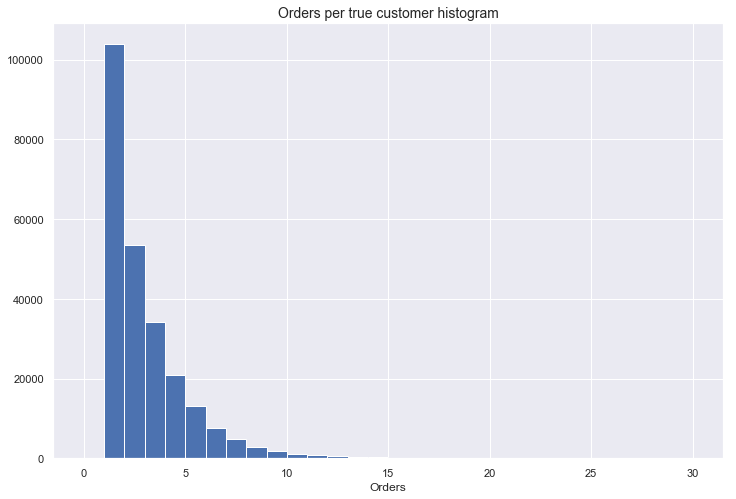

In [61]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(orders_per_customer, bins=30, range=(0, 30))
plt.xlabel('Orders')
plt.title('Orders per true customer histogram', fontsize=14)
plt.show()

In [62]:
Counter(orders_per_customer), np.percentile(orders_per_customer, 99.9)

(Counter({1: 103873,
          2: 53566,
          3: 34208,
          4: 20933,
          5: 13046,
          6: 7709,
          7: 4912,
          8: 2914,
          9: 1820,
          10: 1049,
          11: 714,
          12: 496,
          13: 357,
          14: 239,
          15: 173,
          16: 119,
          17: 92,
          18: 71,
          19: 68,
          20: 35,
          21: 30,
          22: 30,
          23: 29,
          24: 16,
          25: 19,
          26: 17,
          27: 16,
          28: 6,
          29: 7,
          30: 9,
          31: 9,
          32: 6,
          33: 8,
          34: 4,
          35: 3,
          36: 5,
          37: 3,
          38: 3,
          39: 7,
          41: 4,
          42: 1,
          43: 2,
          44: 2,
          46: 1,
          47: 2,
          48: 2,
          53: 1,
          54: 1,
          55: 2,
          56: 1,
          57: 1,
          59: 1,
          62: 1,
          76: 1,
          81: 2,
          87: 1

#### Timedeltas between orders

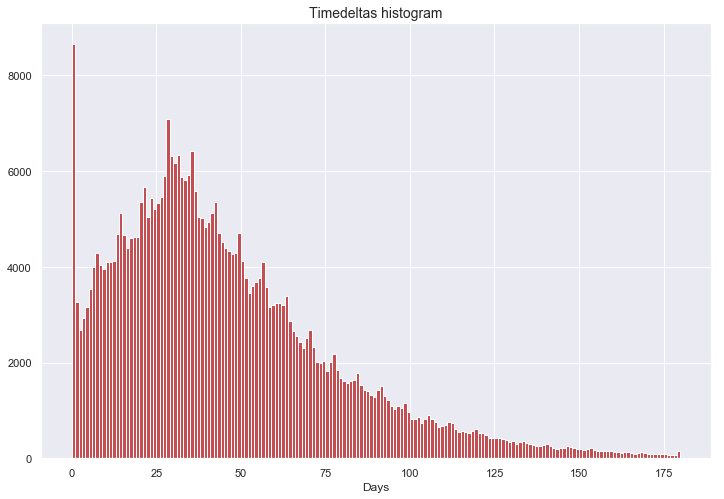

In [63]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(timedeltas_between_orders, bins=180, range=(0, 180), color='r')
plt.xlabel('Days')
plt.title('Timedeltas histogram', fontsize=14)
plt.show()

In [64]:
np.percentile(timedeltas_between_orders, 5)

4.0

#### Delivery zipcodes per true customer

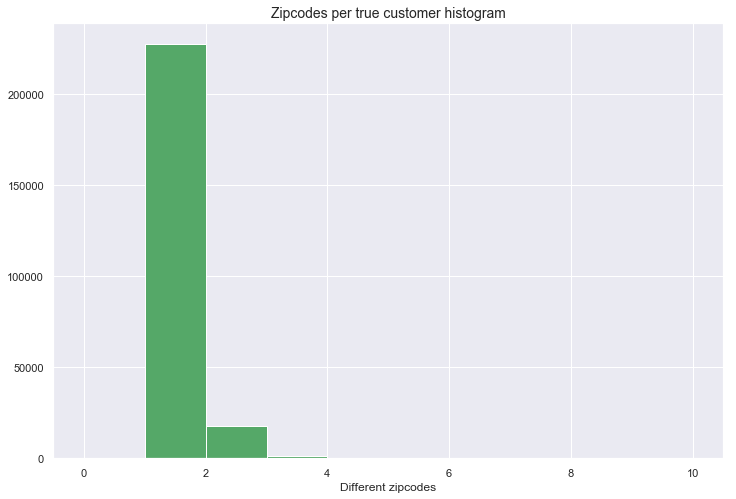

In [65]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(set_zipcodes_per_customer, bins=10, range=(0, 10), color='g')
plt.xlabel('Different zipcodes')
plt.title('Zipcodes per true customer histogram', fontsize=14)
plt.show()

In [66]:
Counter(set_zipcodes_per_customer), np.percentile(set_zipcodes_per_customer, 99.9)

(Counter({1: 227624,
          2: 17523,
          3: 1306,
          4: 148,
          5: 25,
          6: 8,
          7: 2,
          8: 4,
          9: 1,
          10: 1,
          11: 1,
          12: 1,
          15: 1,
          30: 1,
          53: 1,
          60: 1,
          140: 1,
          375: 1,
          788: 1}),
 3.0)

#### Basket Values

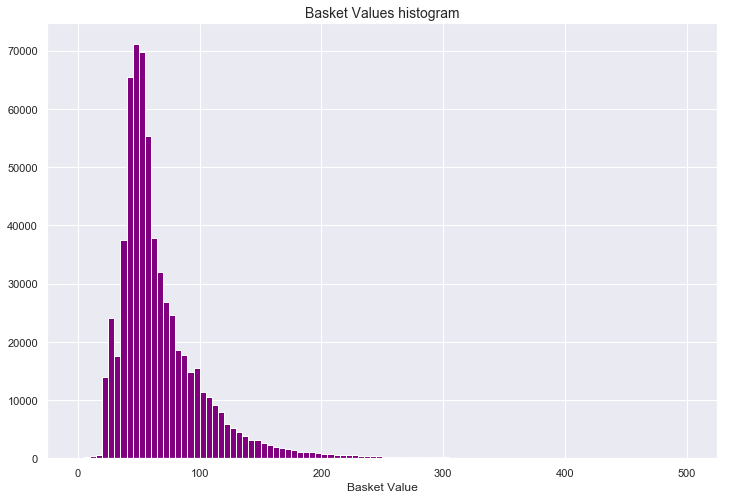

In [67]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(basket_values, bins=100, range=(0, 500), color='purple')
plt.xlabel('Basket Value')
plt.title('Basket Values histogram', fontsize=14)
plt.show()

In [68]:
np.percentile(basket_values, 99.5)

270.7

#### Total sales value

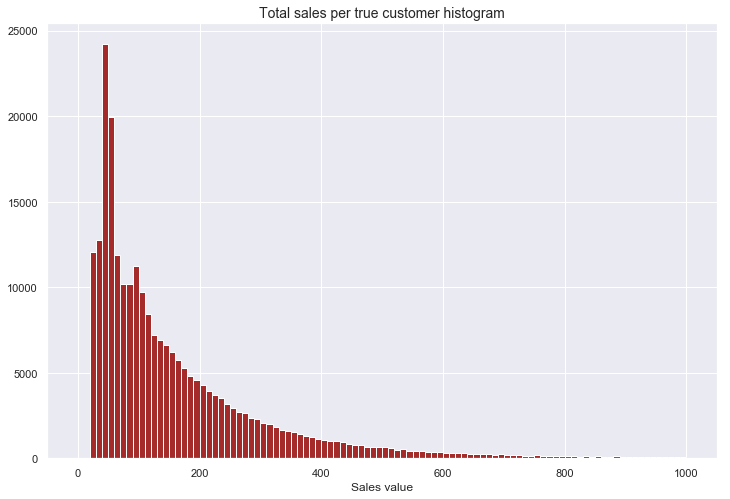

In [69]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(total_sales_values, bins=100, range=(0, 1000), color='brown')
plt.xlabel('Sales value')
plt.title('Total sales per true customer histogram', fontsize=14)
plt.show()

In [70]:
np.max(total_sales_values), np.percentile(total_sales_values, 99.9)

(95342.18, 2337.257000000105)

#### Items per order

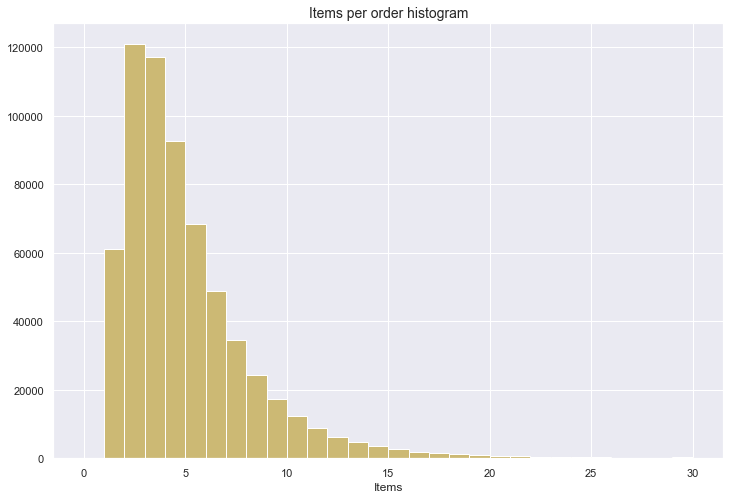

In [71]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(items_per_order, bins=30, range=(0, 30), color='y')
plt.xlabel('Items')
plt.title('Items per order histogram', fontsize=14)
plt.show()

In [72]:
Counter(items_per_order), np.percentile(items_per_order, 99.9)

(Counter({1: 61090,
          2: 120942,
          3: 117223,
          4: 92518,
          5: 68516,
          6: 48898,
          7: 34403,
          8: 24192,
          9: 17250,
          10: 12237,
          11: 8921,
          12: 6365,
          13: 4743,
          14: 3471,
          15: 2581,
          16: 1967,
          17: 1538,
          18: 1238,
          19: 963,
          20: 761,
          21: 691,
          22: 502,
          23: 451,
          24: 373,
          25: 249,
          26: 229,
          27: 191,
          28: 144,
          29: 117,
          30: 128,
          31: 117,
          32: 112,
          33: 79,
          34: 65,
          35: 46,
          36: 56,
          37: 40,
          38: 36,
          39: 29,
          40: 21,
          41: 38,
          42: 17,
          43: 16,
          44: 14,
          45: 17,
          46: 9,
          47: 15,
          48: 16,
          49: 7,
          50: 7,
          51: 9,
          52: 8,
          53: 2,

#### Order positions per order

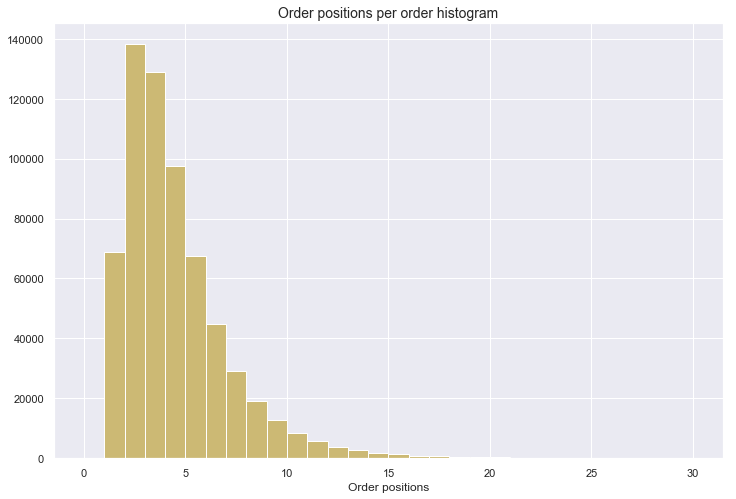

In [73]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(order_positions_per_order, bins=30, range=(0, 30), color='y')
plt.xlabel('Order positions')
plt.title('Order positions per order histogram', fontsize=14)
plt.show()

In [74]:
Counter(order_positions_per_order), np.percentile(order_positions_per_order, 99.9)

(Counter({1: 68882,
          2: 138220,
          3: 128786,
          4: 97527,
          5: 67531,
          6: 44668,
          7: 29220,
          8: 19086,
          9: 12663,
          10: 8335,
          11: 5592,
          12: 3701,
          13: 2740,
          14: 1755,
          15: 1383,
          16: 883,
          17: 665,
          18: 507,
          19: 378,
          20: 252,
          21: 213,
          22: 153,
          23: 138,
          24: 86,
          25: 81,
          26: 53,
          27: 55,
          28: 42,
          29: 25,
          30: 22,
          31: 20,
          32: 15,
          33: 18,
          34: 9,
          35: 4,
          36: 4,
          37: 2,
          38: 10,
          39: 5,
          40: 9,
          41: 4,
          42: 1,
          43: 2,
          44: 1,
          45: 2,
          47: 1,
          48: 4,
          51: 1,
          56: 2,
          60: 1,
          61: 2,
          62: 2,
          84: 1}),
 22.0)

#### Different animals - Lead PG2- per true customer

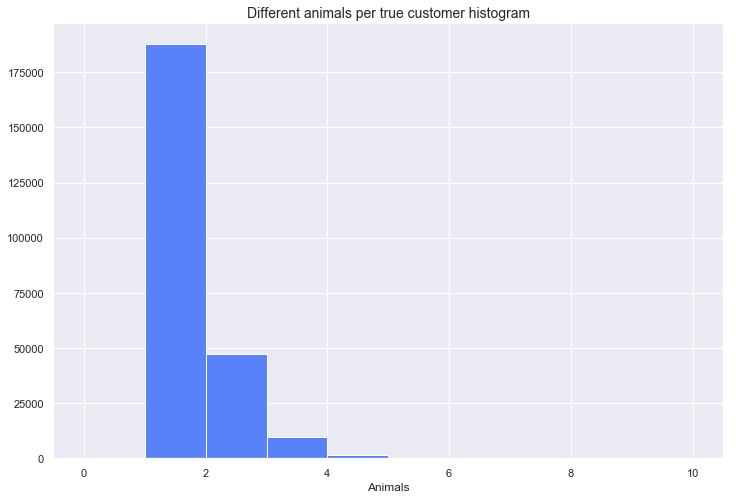

In [75]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(animals_per_customer, bins=10, range=(0, 10), color='#5882FA')
plt.xlabel('Animals')
plt.title('Different animals per true customer histogram', fontsize=14)
plt.show()

In [76]:
np.max(animals_per_customer), np.percentile(animals_per_customer, 99)

(7, 3.0)

In [77]:
Counter(animals_per_customer)

Counter({1: 187745, 2: 47500, 3: 9572, 4: 1557, 5: 237, 6: 37, 7: 3})

#### Different Lead PG3 per true customer

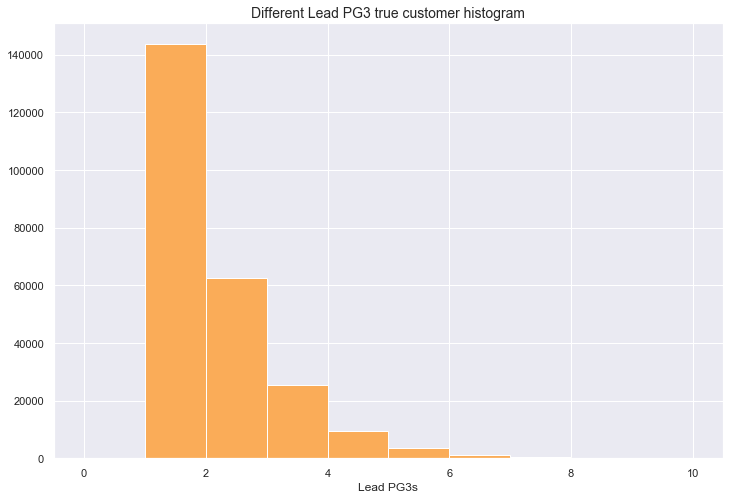

In [78]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(lead_prod_groups_3_per_customer, bins=10, range=(0, 10), color='#FAAC58')
plt.xlabel('Lead PG3s')
plt.title('Different Lead PG3 true customer histogram', fontsize=14)
plt.show()

In [79]:
np.max(lead_prod_groups_3_per_customer), np.percentile(lead_prod_groups_3_per_customer, 99.9)

(21, 8.0)

In [80]:
Counter(lead_prod_groups_3_per_customer)

Counter({1: 143641,
         2: 62359,
         3: 25525,
         4: 9451,
         5: 3544,
         6: 1313,
         7: 490,
         8: 176,
         9: 83,
         10: 39,
         11: 13,
         12: 5,
         13: 7,
         14: 3,
         15: 1,
         21: 1})

#### Brands -Lead PG4- per true customer

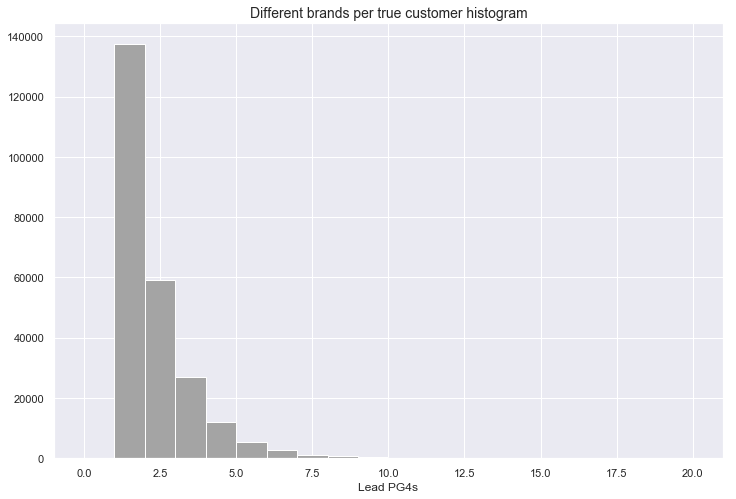

In [81]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(brands_per_customer, bins=20, range=(0, 20), color='#A4A4A4')
plt.xlabel('Lead PG4s')
plt.title('Different brands per true customer histogram', fontsize=14)
plt.show()

In [82]:
np.max(brands_per_customer), np.percentile(brands_per_customer, 99.9)

(56, 11.0)

In [83]:
Counter(brands_per_customer)

Counter({1: 137390,
         2: 59188,
         3: 27038,
         4: 12047,
         5: 5502,
         6: 2630,
         7: 1215,
         8: 700,
         9: 357,
         10: 226,
         11: 113,
         12: 82,
         13: 45,
         14: 25,
         15: 25,
         16: 20,
         17: 12,
         18: 7,
         19: 4,
         20: 7,
         21: 4,
         22: 3,
         23: 3,
         24: 2,
         25: 1,
         26: 2,
         31: 1,
         43: 1,
         56: 1})

#### Different lead shop articles per customer

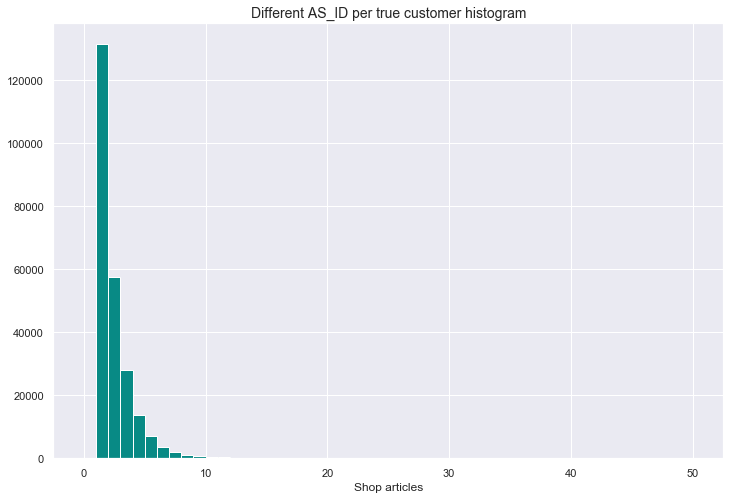

In [84]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(arts_shop_per_customer, bins=50, range=(0, 50), color='#088A85')
plt.xlabel('Shop articles')
plt.title('Different AS_ID per true customer histogram', fontsize=14)
plt.show()

In [85]:
Counter(arts_shop_per_customer), np.percentile(arts_shop_per_customer, 99.9)

(Counter({1: 131347,
          2: 57478,
          3: 28069,
          4: 13870,
          5: 7137,
          6: 3715,
          7: 1982,
          8: 1142,
          9: 698,
          10: 371,
          11: 248,
          12: 170,
          13: 110,
          14: 68,
          15: 63,
          16: 39,
          17: 22,
          18: 15,
          19: 21,
          20: 11,
          21: 12,
          22: 10,
          23: 13,
          24: 5,
          25: 6,
          26: 4,
          27: 1,
          28: 4,
          29: 1,
          31: 1,
          32: 1,
          33: 2,
          34: 2,
          35: 1,
          36: 1,
          39: 1,
          41: 1,
          43: 2,
          48: 1,
          57: 1,
          59: 1,
          60: 1,
          64: 1,
          98: 1,
          127: 1}),
 14.0)

#### Ratio Different Lead AS_ID / Orders 

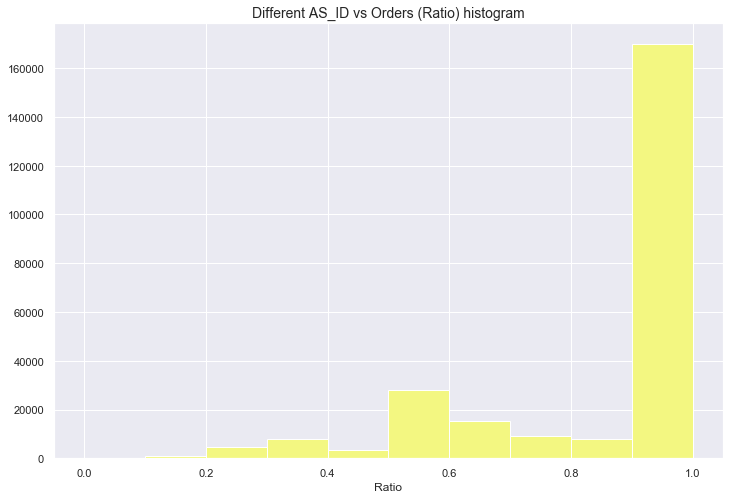

In [86]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(arts_shop_orders_ratio_per_customer, bins=10, range=(0, 1), color='#F3F781')
plt.xlabel('Ratio')
plt.title('Different AS_ID vs Orders (Ratio) histogram', fontsize=14)
plt.show()

In [87]:
Counter(arts_shop_orders_ratio_per_customer), np.percentile(arts_shop_orders_ratio_per_customer, 99)

(Counter({0.067: 2,
          0.077: 1,
          0.083: 2,
          0.091: 8,
          0.095: 1,
          0.1: 14,
          0.111: 34,
          0.125: 94,
          0.133: 2,
          0.143: 241,
          0.154: 2,
          0.167: 465,
          0.176: 1,
          0.182: 16,
          0.188: 2,
          0.2: 1137,
          0.208: 1,
          0.211: 1,
          0.214: 2,
          0.217: 1,
          0.222: 85,
          0.231: 6,
          0.235: 2,
          0.238: 1,
          0.24: 1,
          0.25: 2857,
          0.255: 1,
          0.259: 1,
          0.263: 2,
          0.267: 2,
          0.273: 27,
          0.278: 3,
          0.28: 1,
          0.286: 406,
          0.294: 2,
          0.296: 1,
          0.3: 47,
          0.308: 6,
          0.31: 1,
          0.312: 6,
          0.316: 2,
          0.318: 3,
          0.333: 7314,
          0.341: 2,
          0.348: 3,
          0.35: 2,
          0.353: 5,
          0.357: 9,
          0.36: 1,
          

#### Max order counter per customer

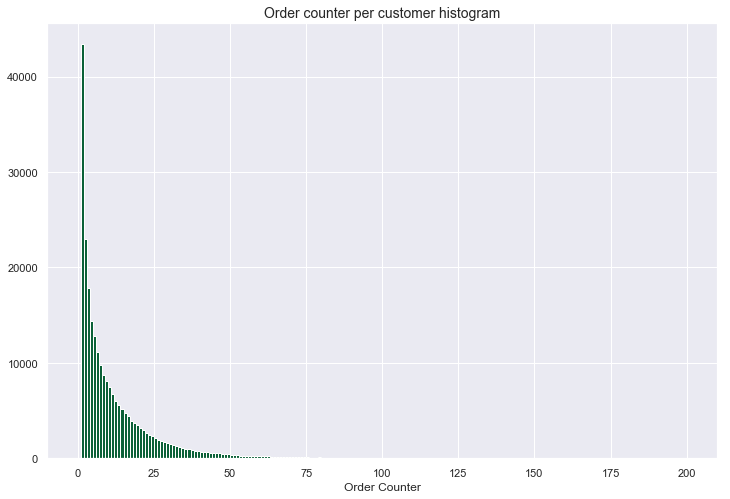

In [88]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(max_order_counter_per_customer, bins=200, range=(0, 200), color='#0B6138')
plt.xlabel('Order Counter')
plt.title('Order counter per customer histogram', fontsize=14)
plt.show()

In [89]:
Counter(max_order_counter_per_customer).most_common(), np.percentile(max_order_counter_per_customer, 99.9)

([(1, 43398),
  (2, 22931),
  (3, 17798),
  (4, 14429),
  (5, 12763),
  (6, 11119),
  (7, 9816),
  (8, 8733),
  (9, 8149),
  (10, 7449),
  (11, 6767),
  (12, 5987),
  (13, 5617),
  (14, 5149),
  (15, 4727),
  (16, 4442),
  (17, 3940),
  (18, 3749),
  (19, 3445),
  (20, 3135),
  (21, 2928),
  (22, 2695),
  (23, 2442),
  (24, 2330),
  (25, 2133),
  (26, 1933),
  (27, 1804),
  (28, 1732),
  (29, 1571),
  (30, 1450),
  (31, 1348),
  (32, 1317),
  (33, 1165),
  (34, 1048),
  (35, 993),
  (36, 969),
  (37, 844),
  (38, 805),
  (39, 777),
  (40, 703),
  (41, 658),
  (42, 611),
  (43, 563),
  (44, 548),
  (45, 516),
  (46, 512),
  (48, 446),
  (47, 434),
  (49, 426),
  (52, 367),
  (50, 351),
  (51, 343),
  (54, 292),
  (53, 291),
  (55, 270),
  (56, 262),
  (58, 238),
  (59, 226),
  (57, 220),
  (62, 203),
  (61, 193),
  (60, 192),
  (63, 173),
  (64, 171),
  (66, 158),
  (65, 156),
  (67, 153),
  (68, 128),
  (69, 127),
  (71, 110),
  (70, 108),
  (72, 98),
  (73, 96),
  (75, 93),
  (74, 90)

### Outlier detection based on percentiles

In [90]:
customers.columns

Index(['TC_ID', 'O_ID_len', 'O_DATE_list', 'O_K_ID_list',
       'OSP_KO_COUNT_NET_list', 'O_K_COUNTER_MAX_list', 'O_GWERT_sum',
       'O_GWERT_list', 'APS_AP_ID_list', 'OP_AS_ID_len_list', 'OP_AS_ID_list',
       'OP_AMOUNT_list', 'LEAD_AS_ID', 'L2_PG_ID', 'L3_PG_ID', 'L4_PG_ID',
       'OCI_PLZ_list', 'O_TIMEDELTAS'],
      dtype='object')

We define here the percentiles of each feature for testing just within our data...

In [91]:
features_percentiles = [np.percentile(orders_per_customer, 99.9), np.percentile(timedeltas_between_orders, 5), 
                                np.percentile(set_zipcodes_per_customer, 99.9), np.percentile(total_sales_values, 99.9), 
                                np.percentile(basket_values, 99.5), np.percentile(items_per_order, 99.9),
                                np.percentile(order_positions_per_order, 99.9),
                                np.percentile(arts_shop_per_customer, 99.9), np.rint(np.percentile(max_order_counter_per_customer, 99.9))]

In [92]:
features_percentiles

[21.0, 4.0, 3.0, 2337.257000000105, 270.7, 33.0, 22.0, 14.0, 157.0]

In [93]:
features_percentiles = pd.DataFrame([features_percentiles], columns=['ORDERS', 
                                                                'TD_PER_ORDER', 'ZIPCODES', 'TOTAL_SALES', 
                                                                'BASKET_VALUE', 'ITEMS_PER_ORDER','O_POS_PER_ORDER',
                                                                'LEAD_AS_IDs', 'ORDER_COUNTER'])

In [94]:
features_percentiles

,ORDERS,TD_PER_ORDER,ZIPCODES,TOTAL_SALES,BASKET_VALUE,ITEMS_PER_ORDER,O_POS_PER_ORDER,LEAD_AS_IDs,ORDER_COUNTER
0,21.0,4.0,3.0,2337.257,270.7,33.0,22.0,14.0,157.0


In [95]:
features_percentiles['TD_PER_ORDER'].values[0]

4.0

We define using a binary classification (0, 1) if the customer or one of his orders is considered as outlier for each of the features tested...

In [96]:
# Variables to check per true customer: orders, different delivery zipcodes, total sales, different lead pg2/pg3/pg4

In [97]:
customers['OUTL_ORDERS'] = [(i > features_percentiles['ORDERS'].values[0]) * 1 for i in customers['O_ID_len'].values]

In [98]:
customers['OUTL_OCI_PLZ'] = [(len(i.keys()) > features_percentiles['ZIPCODES'].values[0]) * 1 for i in customers['OCI_PLZ_list'].values]

In [99]:
customers['OUTL_TOT_O_GWERT'] = [(i > features_percentiles['TOTAL_SALES'].values[0]) * 1 for i in customers['O_GWERT_sum'].values]

In [100]:
#customers['OUTL_PG2'] = [(len(i.keys()) > features_percentiles['PG2'].values[0]) * 1 for i in customers['L2_PG_ID'].values]

In [101]:
#customers['OUTL_PG3'] = [(len(i.keys()) > features_percentiles['PG3'].values[0]) * 1 for i in customers['L3_PG_ID'].values]

In [102]:
#customers['OUTL_PG4'] = [(len(i.keys()) > features_percentiles['PG4'].values[0]) * 1 for i in customers['L4_PG_ID'].values]

In [103]:
customers['OUTL_AS_IDs'] = [(len(i.keys()) > features_percentiles['LEAD_AS_IDs'].values[0]) * 1 for i in customers['LEAD_AS_ID'].values]

In [104]:
customers['OUTL_O_COUNTER'] = [(sum(i) > features_percentiles['ORDER_COUNTER'].values[0]) * 1 for i in customers['O_K_COUNTER_MAX_list'].values]

In [105]:
# Variables to check per order belonging to the customer: timedeltas between orders, basket values, items per order

In [106]:
# For this variable let's start with the percentile 5 (4 days timedelta) instead of percentile 2.5 (1 day)
customers['OUTL_TIMEDELTAS'] = [[(j < features_percentiles['TD_PER_ORDER'].values[0]) * 1 if len(i) >= 1 else i for j in i]
                                    for i in customers['O_TIMEDELTAS'].values]

In [107]:
customers['OUTL_BASKET_VALUES'] = [[(j > features_percentiles['BASKET_VALUE'].values[0]) * 1 for j in i]
                                for i in customers['O_GWERT_list'].values]

In [108]:
customers['OUTL_ITEMS'] = [[(sum(j) > features_percentiles['ITEMS_PER_ORDER'].values[0]) * 1 for j in i]
                                for i in customers['OP_AMOUNT_list'].values]

In [109]:
customers['OUTL_O_POS'] = [[(j > features_percentiles['O_POS_PER_ORDER'].values[0]) * 1 for j in i]
                                for i in customers['OP_AS_ID_len_list'].values]

In [110]:
# For last three variables let's compute the relevance of outliers within their all orders

In [111]:
customers['OUTL_TD_%'] = [np.round(sum(i)/len(i), 3) if sum(i) >= 1 else 0 for i in customers['OUTL_TIMEDELTAS'].values]

In [112]:
customers['OUTL_BV_%'] = [np.round(sum(i)/len(i), 3) if sum(i) >= 1 else 0 for i in customers['OUTL_BASKET_VALUES'].values]

In [113]:
customers['OUTL_ITEMS_%'] = [np.round(sum(i)/len(i), 3) if sum(i) >= 1 else 0 for i in customers['OUTL_ITEMS'].values]

In [114]:
customers['OUTL_O_POS_%'] = [np.round(sum(i)/len(i), 3) if sum(i) >= 1 else 0 for i in customers['OUTL_O_POS'].values]

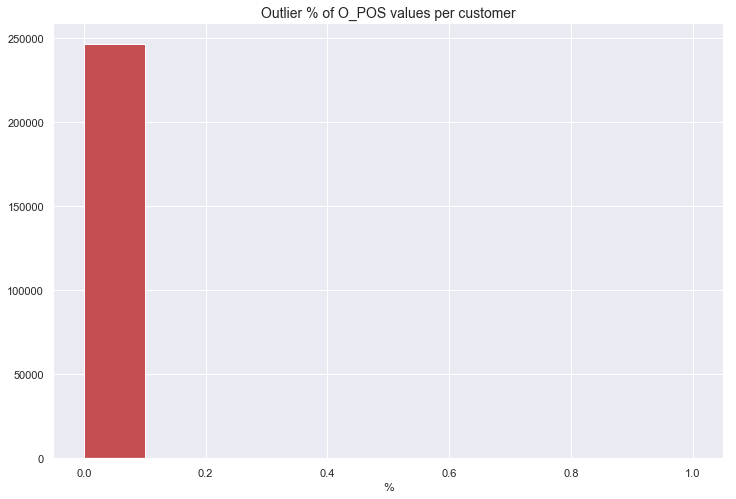

In [115]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(customers['OUTL_O_POS_%'], bins=10, range=(0, 1), color='r')
plt.xlabel('%')
plt.title('Outlier % of O_POS values per customer', fontsize=14)
plt.show()

In [116]:
Counter(customers['OUTL_O_POS_%'].values)

Counter({0.0: 246231,
         0.012: 1,
         0.019: 1,
         0.027: 1,
         0.03: 1,
         0.032: 1,
         0.033: 1,
         0.037: 1,
         0.038: 1,
         0.048: 1,
         0.05: 1,
         0.053: 1,
         0.056: 1,
         0.059: 1,
         0.062: 1,
         0.067: 2,
         0.071: 4,
         0.074: 1,
         0.077: 3,
         0.083: 9,
         0.091: 6,
         0.1: 9,
         0.111: 23,
         0.118: 1,
         0.125: 24,
         0.133: 1,
         0.143: 27,
         0.148: 1,
         0.154: 2,
         0.167: 32,
         0.182: 6,
         0.2: 22,
         0.211: 1,
         0.222: 4,
         0.231: 1,
         0.25: 37,
         0.286: 5,
         0.3: 1,
         0.308: 1,
         0.333: 38,
         0.368: 1,
         0.4: 8,
         0.429: 3,
         0.5: 60,
         0.556: 4,
         0.571: 1,
         0.6: 3,
         0.625: 2,
         0.667: 4,
         0.714: 3,
         0.75: 6,
         0.875: 1,
         1.0: 49}

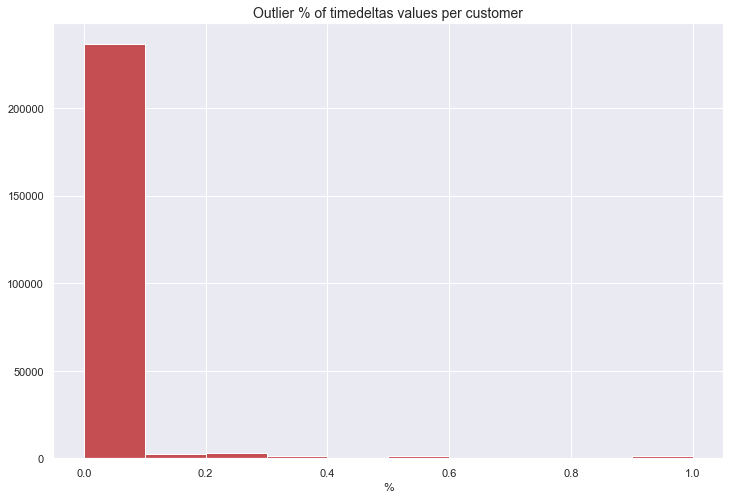

In [117]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(customers['OUTL_TD_%'], bins=10, range=(0, 1), color='r')
plt.xlabel('%')
plt.title('Outlier % of timedeltas values per customer', fontsize=14)
plt.show()

In [118]:
Counter(customers['OUTL_TD_%'].values)

Counter({0.0: 236121,
         0.034: 1,
         0.038: 2,
         0.042: 2,
         0.045: 3,
         0.048: 1,
         0.05: 2,
         0.053: 5,
         0.056: 9,
         0.059: 16,
         0.062: 19,
         0.067: 34,
         0.071: 41,
         0.077: 74,
         0.08: 2,
         0.083: 109,
         0.087: 3,
         0.091: 150,
         0.095: 3,
         0.1: 205,
         0.105: 5,
         0.107: 1,
         0.111: 312,
         0.115: 1,
         0.118: 12,
         0.12: 2,
         0.125: 447,
         0.13: 2,
         0.133: 29,
         0.136: 2,
         0.143: 634,
         0.147: 1,
         0.15: 4,
         0.154: 50,
         0.158: 3,
         0.161: 1,
         0.167: 838,
         0.172: 1,
         0.174: 4,
         0.176: 14,
         0.179: 2,
         0.182: 66,
         0.185: 1,
         0.188: 14,
         0.19: 7,
         0.192: 1,
         0.2: 1088,
         0.207: 2,
         0.208: 3,
         0.211: 4,
         0.214: 25,
         

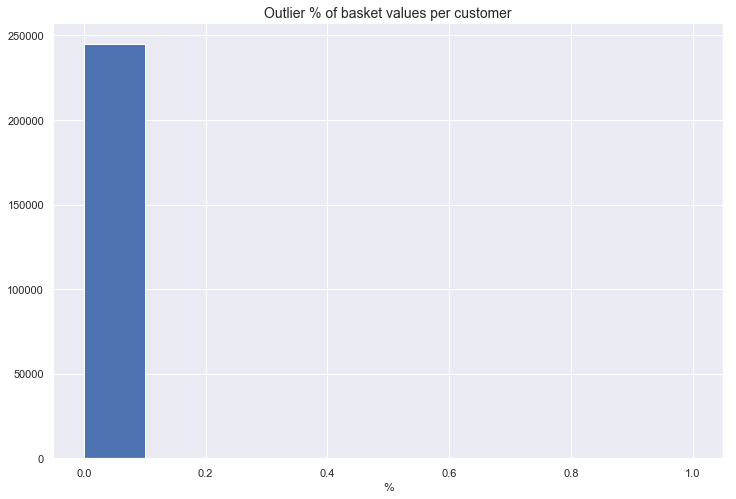

In [119]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(customers['OUTL_BV_%'], bins=10, range=(0, 1), color='b')
plt.xlabel('%')
plt.title('Outlier % of basket values per customer', fontsize=14)
plt.show()

In [120]:
Counter(customers['OUTL_BV_%'].values)

Counter({0.0: 244708,
         0.011: 1,
         0.019: 1,
         0.02: 1,
         0.021: 1,
         0.026: 2,
         0.029: 2,
         0.03: 1,
         0.032: 1,
         0.033: 1,
         0.035: 1,
         0.037: 2,
         0.038: 1,
         0.04: 2,
         0.042: 1,
         0.043: 2,
         0.045: 2,
         0.048: 2,
         0.05: 1,
         0.053: 3,
         0.056: 5,
         0.057: 1,
         0.059: 3,
         0.061: 1,
         0.062: 8,
         0.067: 8,
         0.068: 1,
         0.071: 13,
         0.074: 1,
         0.077: 15,
         0.083: 21,
         0.087: 2,
         0.091: 16,
         0.097: 1,
         0.1: 30,
         0.105: 1,
         0.111: 27,
         0.114: 1,
         0.118: 2,
         0.12: 1,
         0.123: 1,
         0.125: 59,
         0.133: 4,
         0.143: 53,
         0.15: 3,
         0.152: 1,
         0.154: 3,
         0.158: 3,
         0.167: 84,
         0.182: 3,
         0.185: 1,
         0.188: 1,
        

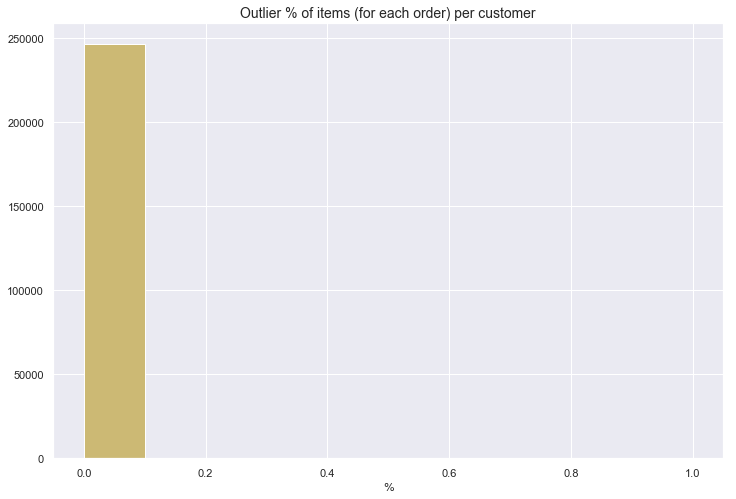

In [121]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(customers['OUTL_ITEMS_%'], bins=10, range=(0, 1), color='y')
plt.xlabel('%')
plt.title('Outlier % of items (for each order) per customer', fontsize=14)
plt.show()

In [122]:
Counter(customers['OUTL_ITEMS_%'].values)

Counter({0.0: 246290,
         0.001: 1,
         0.006: 1,
         0.026: 1,
         0.028: 1,
         0.03: 1,
         0.031: 1,
         0.037: 1,
         0.04: 2,
         0.045: 3,
         0.05: 2,
         0.053: 4,
         0.054: 1,
         0.062: 2,
         0.067: 3,
         0.071: 7,
         0.074: 1,
         0.077: 6,
         0.083: 7,
         0.091: 5,
         0.099: 1,
         0.1: 7,
         0.105: 2,
         0.111: 22,
         0.115: 1,
         0.118: 1,
         0.12: 1,
         0.125: 7,
         0.133: 1,
         0.139: 1,
         0.143: 18,
         0.154: 1,
         0.159: 1,
         0.167: 16,
         0.182: 1,
         0.2: 25,
         0.222: 1,
         0.25: 31,
         0.286: 6,
         0.294: 1,
         0.333: 42,
         0.357: 1,
         0.364: 1,
         0.375: 1,
         0.4: 6,
         0.429: 1,
         0.444: 2,
         0.5: 45,
         0.571: 1,
         0.583: 1,
         0.6: 1,
         0.625: 1,
         0.667: 8

### Outlier score

In [123]:
customers.columns

Index(['TC_ID', 'O_ID_len', 'O_DATE_list', 'O_K_ID_list',
       'OSP_KO_COUNT_NET_list', 'O_K_COUNTER_MAX_list', 'O_GWERT_sum',
       'O_GWERT_list', 'APS_AP_ID_list', 'OP_AS_ID_len_list', 'OP_AS_ID_list',
       'OP_AMOUNT_list', 'LEAD_AS_ID', 'L2_PG_ID', 'L3_PG_ID', 'L4_PG_ID',
       'OCI_PLZ_list', 'O_TIMEDELTAS', 'OUTL_ORDERS', 'OUTL_OCI_PLZ',
       'OUTL_TOT_O_GWERT', 'OUTL_AS_IDs', 'OUTL_O_COUNTER', 'OUTL_TIMEDELTAS',
       'OUTL_BASKET_VALUES', 'OUTL_ITEMS', 'OUTL_O_POS', 'OUTL_TD_%',
       'OUTL_BV_%', 'OUTL_ITEMS_%', 'OUTL_O_POS_%'],
      dtype='object')

Let's calculate a score involving the outlier status of: orders, different delivery zipcodes, total sales, % of outlier timedeltas, % of outlier basket values and % of outlier items as follows:

In [124]:
customers['OUTLIER_SCORE'] = np.rint(customers['OUTL_ORDERS'] + customers['OUTL_OCI_PLZ'] + customers['OUTL_TOT_O_GWERT'] + 
                            customers['OUTL_AS_IDs'] + customers['OUTL_O_COUNTER'] + 
                            customers['OUTL_TD_%'] + customers['OUTL_BV_%'] + 
                            customers['OUTL_ITEMS_%'] + customers['OUTL_O_POS_%'])

In [125]:
customers['OUTLIER_SCORE'].describe()

count    246651.000000
mean          0.014466
std           0.151356
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           6.000000
Name: OUTLIER_SCORE, dtype: float64

This is the amount of customers belonging to each score:

In [126]:
Counter(customers['OUTLIER_SCORE'].values)

Counter({0.0: 243760, 1.0: 2469, 2.0: 263, 3.0: 94, 4.0: 42, 5.0: 15, 6.0: 8})

### 'Resellers'

As a first approach, let's label as 'long-term resellers' those being outliers at:
- total sales 
- orders
- order counter

In [127]:
# Long term resellers: caught by orders or total sales surpassing the percentiles
customers['LT_RESELLERS'] = ((customers['OUTL_ORDERS']) | (customers['OUTL_TOT_O_GWERT']) | 
                             customers['OUTL_O_COUNTER']) * 1

In [128]:
# 524 detected
customers['LT_RESELLERS'].value_counts()

0    246127
1       524
Name: LT_RESELLERS, dtype: int64

In [129]:
customers[customers['LT_RESELLERS'] == 1]['OUTLIER_SCORE'].value_counts()

1.0    203
2.0    172
3.0     84
4.0     42
5.0     15
6.0      8
Name: OUTLIER_SCORE, dtype: int64

In [130]:
customers[customers['LT_RESELLERS'] == 1].sample(10)

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,APS_AP_ID_list,OP_AS_ID_len_list,...,OUTL_TIMEDELTAS,OUTL_BASKET_VALUES,OUTL_ITEMS,OUTL_O_POS,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%,OUTLIER_SCORE,LT_RESELLERS
8912,224125,12,"[2018-03-15 17:45:54, 2018-03-23 21:14:07, 201...",[6337945],"[100, 101, 102, 103, 104, 105, 106, 108, 108, ...",[112],2948.11,"[274.74, 111.7, 294.9, 111.7, 33.42, 156.63, 1...","[[26783, 73409, 69571, 74242, 6169, 69577, 616...","[8, 2, 11, 2, 2, 16, 9, 23, 19, 8, 26, 22]",...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]",0.091,0.417,0.083,0.167,2.0,1
8156,203274,23,"[2018-03-09 16:21:19, 2018-03-22 10:13:58, 201...",[11082511],"[63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 7...",[85],1486.30,"[76.46, 54.16, 86.62, 48.16, 58.45, 59.97, 48....","[[68059, 66226, 27175, 50337], [16619, 50341, ...","[4, 3, 8, 4, 3, 2, 7, 2, 5, 9, 4, 4, 5, 8, 7, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.045,0.000,0.000,0.000,1.0,1
26776,2794087,23,"[2018-03-12 14:37:18, 2018-04-04 20:16:50, 201...",[3220645],"[52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 6...",[74],1969.76,"[44.63, 42.24, 49.37, 37.95, 40.81, 37.97, 38....","[[67405, 28168, 42715], [67405, 75094, 64250, ...","[3, 5, 4, 5, 4, 4, 3, 6, 3, 4, 3, 5, 5, 3, 7, ...",...,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.273,0.000,0.000,0.000,2.0,1
23592,2353050,25,"[2018-03-06 11:19:51, 2018-03-24 15:46:03, 201...","[2746006, 4640049]","[76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 8...","[88, 73]",3737.44,"[256.03, 39.75, 106.66, 153.22, 68.85, 60.11, ...","[[61298, 77102, 42715], [42715, 28398, 34269, ...","[3, 4, 3, 4, 4, 4, 3, 4, 3, 3, 3, 3, 3, 2, 2, ...",...,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.208,0.000,0.000,0.000,3.0,1
19079,773886,4,"[2018-03-10 18:13:45, 2018-03-12 17:25:54, 201...",[501115],"[175, 176, 177, 181]",[181],191.14,"[18.6, 3.71, 124.2, 44.63]","[[25838, 42715], [3135, 25854, 6169, 42715], [...","[2, 4, 6, 3]",...,"[1, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]",0.333,0.000,0.000,0.000,1.0,1
11073,281362,30,"[2018-03-05 12:46:13, 2018-03-12 08:33:01, 201...",[3468525],"[189, 190, 191, 192, 193, 194, 195, 196, 197, ...",[218],2530.47,"[83.8, 87.77, 56.48, 56.31, 95.7, 98.13, 84.95...","[[64434, 63031, 30682, 50341, 62951, 32605, 42...","[13, 14, 12, 11, 13, 13, 13, 13, 12, 14, 13, 1...",...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.034,0.000,0.000,0.000,3.0,1
580,13652,28,"[2018-04-09 08:48:35, 2018-04-09 09:18:44, 201...",[2791530],"[78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 8...",[105],1563.52,"[86.74, 85.79, 39.75, 50.83, 36.56, 63.59, 43....","[[72265, 67737, 60987, 61247, 72929, 64677, 73...","[8, 6, 3, 4, 4, 6, 2, 6, 5, 5, 10, 7, 7, 3, 2,...",...,"[1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.556,0.000,0.000,0.000,3.0,1
779,18242,16,"[2018-03-07 16:54:10, 2018-03-25 14:33:35, 201...",[14397137],"[27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 3...",[42],2721.89,"[38.86, 126.47, 129.54, 64.77, 98.99, 135.15, ...","[[50340, 6169], [20886, 6169, 

### Early detection

For those not entering the previous group but having also an abnormal behaviour let's focus on other features. Some of them will be evaluated at an order-level:
    - % of outlier in timedeltas >= 70%
    - % of outlier in basket values >= 70%
    - % of outlier in items per order >= 70%
and others aggregated as:
    - different delivery zipcodes >= 4
    - +14 different Lead AS_IDs
    - have a minimum amount of orders >= 5

In [131]:
# Early detection: caught by timedeltas between orders, % of basket values above the percentiles, zipcodes...
customers['ED'] = ((
                              (customers['OUTL_TD_%'] >= 0.7) | 
                              (customers['OUTL_BV_%'] >= 0.7) |
                              (customers['OUTL_ITEMS_%'] >= 0.7) |
                              (customers['OUTL_OCI_PLZ'] == 1) |
                              (customers['OUTL_AS_IDs'] == 1) 
                             ) &
                             (customers['O_ID_len'] >= 5) & (customers['LT_RESELLERS'] == 0)) * 1

In [132]:
# 265 detected
customers['ED'].value_counts()

0    246387
1       264
Name: ED, dtype: int64

In [133]:
# TC scores in early detection
customers[customers['ED'] == 1]['OUTLIER_SCORE'].value_counts()

1.0    253
2.0     11
Name: OUTLIER_SCORE, dtype: int64

#### Delivery zipcodes

In [134]:
customers[customers['ED'] == 1]['OUTL_OCI_PLZ'].value_counts()

1    157
0    107
Name: OUTL_OCI_PLZ, dtype: int64

In [135]:
ed_res_zipcode = customers[(customers['ED'] == 1) & (customers['OUTL_OCI_PLZ'] == 1)] 

In [136]:
ed_res_zipcode.sample(5)

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,APS_AP_ID_list,OP_AS_ID_len_list,...,OUTL_BASKET_VALUES,OUTL_ITEMS,OUTL_O_POS,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%,OUTLIER_SCORE,LT_RESELLERS,ED
26614,2769971,9,"[2018-03-22 11:47:00, 2018-04-01 13:45:41, 201...",[6309904],"[12, 13, 15, 16, 17, 18, 19, 20, 21]",[21],1170.67,"[119.9, 188.97, 139.93, 98.99, 89.99, 109.98, ...","[[63762], [60445, 60370, 68150], [37446, 52372...","[1, 3, 6, 1, 1, 1, 1, 2, 1]",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.250,0.000,0.0,0.0,1.0,0,1
184832,14127134,6,"[2018-03-25 23:32:15, 2018-05-02 14:29:25, 201...",[19342939],"[4, 5, 6, 7, 8, 9]",[9],1982.87,"[439.1, 386.82, 253.89, 492.74, 63.96, 346.36]","[[57812, 26662, 50341, 64699], [50341, 28053, ...","[4, 11, 3, 10, 1, 7]",...,"[1, 1, 0, 1, 0, 1]","[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]",0.200,0.667,0.0,0.0,2.0,0,1
182005,14000287,9,"[2018-03-09 21:43:20, 2018-04-14 11:03:07, 201...",[19152517],"[2, 3, 4, 5, 6, 7, 8, 9, 10]",[10],673.05,"[104.24, 35.04, 99.23, 80.23, 85.06, 39.94, 47...","[[6169, 57806, 49431, 73769, 64678, 66604, 422...","[9, 4, 7, 6, 8, 4, 7, 7, 5]",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.250,0.000,0.0,0.0,1.0,0,1
29823,3158790,8,"[2018-03-05 22:59:21, 2018-05-03 17:52:55, 201...",[3671696],"[61, 62, 63, 64, 65, 66, 67, 68]",[68],360.48,"[51.31, 39.44, 39.28, 42.66, 38.75, 48.43, 50....","[[66873, 66869, 63782, 63782, 66947, 66944, 42...","[7, 5, 3, 7, 6, 5, 5, 5]",...,"[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]",0.143,0.000,0.0,0.0,1.0,0,1
151561,12426892,6,"[2018-03-19 13:39:44, 2018-04-24 10:42:21, 201...",[16843207],"[6, 7, 8, 9, 10, 11]",[11],372.35,"[52.98, 76.97, 54.99, 96.46, 51.98, 38.97]","[[67665, 6169, 72611, 55406], [67404, 55406, 5...","[4, 3, 1, 6, 2, 3]",...,"[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]",0.200,0.000,0.0,0.0,1.0,0,1


In [137]:
ed_res_zipcode.loc[206268]

TC_ID                                                             14764309
O_ID_len                                                                13
O_DATE_list              [2018-04-30 13:57:19, 2018-06-10 10:39:23, 201...
O_K_ID_list                                                     [20097098]
OSP_KO_COUNT_NET_list         [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 11, 12, 13]
O_K_COUNTER_MAX_list                                                  [13]
O_GWERT_sum                                                         871.95
O_GWERT_list             [243.89, 50.32, 46.69, 46.69, 78.54, 39.96, 73...
APS_AP_ID_list           [[71428, 42225, 17543, 66378, 6169, 60449, 703...
OP_AS_ID_len_list                  [8, 5, 3, 3, 4, 4, 2, 4, 3, 4, 4, 5, 8]
OP_AS_ID_list            [[2033923, 906044, 323875, 2051339, 1, 1285462...
OP_AMOUNT_list           [[1, 1, 6, 4, 1, 1, 1, 1], [1, 1, 1, 1, 1], [4...
LEAD_AS_ID               {2042610: 1, 1990101: 1, 323875: 5, 897400: 1,...
L2_PG_ID                 

https://cc-admin.prod.zooplus.net/phpadmin/cc/customer/detail/cId-20097098
<html><head>


<!-- Load require.js. Delete this if your page already loads require.js -->
<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.4/require.min.js" integrity="sha256-Ae2Vz/4ePdIu6ZyI/5ZGsYnb+m0JlOmKPjt6XZ9JJkA=" crossorigin="anonymous"></script>
<script src="https://unpkg.com/@jupyter-widgets/html-manager@*/dist/embed-amd.js" crossorigin="anonymous"></script>
<script type="application/vnd.jupyter.widget-state+json">
{
    "version_major": 2,
    "version_minor": 0,
    "state": {}
}
</script>
</head>
<body>


</body>
</html>
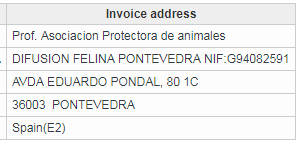

In [138]:
ed_res_zipcode.loc[138]

TC_ID                                                                 3201
O_ID_len                                                                10
O_DATE_list              [2018-03-20 17:20:53, 2018-03-26 20:54:25, 201...
O_K_ID_list                                                      [6806274]
OSP_KO_COUNT_NET_list             [50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
O_K_COUNTER_MAX_list                                                  [59]
O_GWERT_sum                                                         448.05
O_GWERT_list             [40.28, 39.99, 41.46, 47.98, 49.99, 60.47, 36....
APS_AP_ID_list           [[42647, 70762], [69136], [61348, 68059, 61191...
OP_AS_ID_len_list                           [2, 1, 4, 2, 1, 5, 2, 4, 3, 2]
OP_AS_ID_list            [[2370345, 1993161], [1904593], [1316367, 1806...
OP_AMOUNT_list           [[1, 1], [1], [1, 1, 1, 1], [1, 1], [1], [1, 1...
LEAD_AS_ID               {1993161: 1, 1904593: 1, 1310923: 1, 2324859: ...
L2_PG_ID                 

https://cc-admin.prod.zooplus.net/phpadmin/cc/customer/detail/cId-6806274

In [139]:
ed_res_zipcode.loc[219498]

TC_ID                                                             15119785
O_ID_len                                                                 5
O_DATE_list              [2018-06-15 04:18:25, 2018-07-18 15:15:48, 201...
O_K_ID_list                                                     [20481855]
OSP_KO_COUNT_NET_list                                      [1, 2, 4, 4, 5]
O_K_COUNTER_MAX_list                                                   [5]
O_GWERT_sum                                                         233.61
O_GWERT_list                           [75.97, 65.25, 24.45, 34.97, 32.97]
APS_AP_ID_list           [[77023, 18918, 65421], [60939, 2820, 26500, 3...
OP_AS_ID_len_list                                          [3, 5, 5, 3, 3]
OP_AS_ID_list            [[2297572, 324402, 1642896], [1416472, 322663,...
OP_AMOUNT_list           [[1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], ...
LEAD_AS_ID               {1642896: 1, 1416472: 1, 1543600: 1, 2297542: ...
L2_PG_ID                 

https://cc-admin.prod.zooplus.net/phpadmin/cc/customer/detail/cId-20481855

#### Different AS_IDs

In [140]:
customers[customers['ED'] == 1]['OUTL_AS_IDs'].value_counts()

0    197
1     67
Name: OUTL_AS_IDs, dtype: int64

In [141]:
ed_res_as_ids = customers[(customers['ED'] == 1) & (customers['OUTL_AS_IDs'] == 1)] 

In [142]:
ed_res_as_ids.sample(5)

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,APS_AP_ID_list,OP_AS_ID_len_list,...,OUTL_BASKET_VALUES,OUTL_ITEMS,OUTL_O_POS,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%,OUTLIER_SCORE,LT_RESELLERS,ED
177458,13792843,16,"[2018-03-04 21:25:18, 2018-03-23 13:34:03, 201...",[18840857],"[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, ...",[22],1201.83,"[59.58, 90.9, 61.55, 97.42, 85.28, 114.38, 66....","[[71081, 63373, 62611, 69101, 71131, 63371, 62...","[9, 10, 6, 8, 9, 9, 5, 8, 4, 6, 5, 8, 4, 9, 13...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.067,0.0,0.0,0.0,1.0,0,1
156125,12644833,18,"[2018-03-02 23:48:58, 2018-03-16 17:20:34, 201...",[17156572],"[22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 3...",[39],1188.01,"[42.97, 53.96, 46.62, 85.11, 74.92, 72.11, 70....","[[55166, 70091, 61291, 77422, 55062], [6169, 5...","[5, 5, 15, 9, 7, 11, 8, 10, 5, 4, 4, 5, 12, 6,...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.059,0.0,0.0,0.0,1.0,0,1
10329,259918,19,"[2018-03-05 10:03:27, 2018-03-19 10:45:37, 201...",[7766561],"[93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 10...",[111],870.46,"[61.08, 38.05, 58.19, 71.75, 40.64, 45.55, 43....","[[64107, 64056, 64621, 64105, 71892, 66698, 60...","[9, 11, 2, 4, 6, 4, 3, 3, 2, 5, 11, 6, 2, 6, 3...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.111,0.0,0.0,0.0,1.0,0,1
26664,2777774,17,"[2018-03-11 18:27:27, 2018-03-25 22:01:46, 201...",[3200220],"[108, 109, 110, 111, 112, 113, 114, 115, 116, ...",[124],1094.90,"[85.69, 55.76, 82.04, 62.55, 41.66, 67.87, 51....","[[72929, 74940, 35709, 68967, 66871, 10954, 42...","[7, 3, 5, 3, 6, 5, 4, 3, 8, 3, 3, 4, 5, 6, 4, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000,0.0,0.0,0.0,1.0,0,1
1435,34679,21,"[2018-03-19 17:56:08, 2018-03-19 18:09:48, 201...",[6890348],"[58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 6...",[78],1201.25,"[53.29, 50.41, 98.0, 51.19, 34.2, 35.83, 48.46...","[[6169, 55406, 64848, 65466, 42715], [64848, 1...","[5, 5, 6, 6, 5, 5, 4, 4, 9, 5, 4, 4, 8, 9, 7, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.450,0.0,0.0,0.0,2.0,0,1


In [143]:
#La loca de los gatos
ed_res_as_ids.loc[227932]

TC_ID                                                             15386713
O_ID_len                                                                15
O_DATE_list              [2018-07-20 10:16:46, 2018-07-21 17:40:58, 201...
O_K_ID_list                                                     [20768304]
OSP_KO_COUNT_NET_list    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
O_K_COUNTER_MAX_list                                                  [15]
O_GWERT_sum                                                         533.76
O_GWERT_list             [38.98, 23.96, 49.88, 25.29, 24.96, 23.34, 41....
APS_AP_ID_list           [[54220, 6168], [64305, 64632, 6168], [64028, ...
OP_AS_ID_len_list            [2, 3, 9, 5, 4, 6, 7, 4, 3, 6, 5, 5, 8, 6, 7]
OP_AS_ID_list            [[1485845, 2], [1601153, 1568623, 2], [1542726...
OP_AMOUNT_list           [[1, 1], [2, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1...
LEAD_AS_ID               {1485845: 1, 1568623: 1, 1485844: 1, 1601153: ...
L2_PG_ID                 

https://cc-admin.prod.zooplus.net/phpadmin/cc/customer/detail/cId-20768304

In [144]:
ed_res_as_ids.loc[41242]

TC_ID                                                              4503671
O_ID_len                                                                21
O_DATE_list              [2018-03-04 20:47:39, 2018-03-07 22:48:56, 201...
O_K_ID_list                                                      [5406286]
OSP_KO_COUNT_NET_list    [101, 102, 103, 104, 105, 106, 107, 108, 109, ...
O_K_COUNTER_MAX_list                                                 [121]
O_GWERT_sum                                                        2138.37
O_GWERT_list             [158.89, 100.85, 143.94, 136.31, 52.34, 95.8, ...
APS_AP_ID_list           [[6169, 73552, 62406, 62985, 58927, 50340, 321...
OP_AS_ID_len_list        [10, 5, 10, 7, 6, 7, 4, 12, 3, 8, 4, 10, 5, 5,...
OP_AS_ID_list            [[1, 2223201, 1384262, 1510334, 1440435, 15842...
OP_AMOUNT_list           [[1, 2, 1, 1, 1, 1, 1, 2, 1, 1], [1, 1, 1, 1, ...
LEAD_AS_ID               {2223201: 1, 2339856: 2, 323871: 3, 2398596: 1...
L2_PG_ID                 

https://cc-admin.prod.zooplus.net/phpadmin/cc/customer/detail/cId-5406286

In [145]:
ed_res_as_ids.loc[26664]

TC_ID                                                              2777774
O_ID_len                                                                17
O_DATE_list              [2018-03-11 18:27:27, 2018-03-25 22:01:46, 201...
O_K_ID_list                                                      [3200220]
OSP_KO_COUNT_NET_list    [108, 109, 110, 111, 112, 113, 114, 115, 116, ...
O_K_COUNTER_MAX_list                                                 [124]
O_GWERT_sum                                                         1094.9
O_GWERT_list             [85.69, 55.76, 82.04, 62.55, 41.66, 67.87, 51....
APS_AP_ID_list           [[72929, 74940, 35709, 68967, 66871, 10954, 42...
OP_AS_ID_len_list        [7, 3, 5, 3, 6, 5, 4, 3, 8, 3, 3, 4, 5, 6, 4, ...
OP_AS_ID_list            [[2364659, 2364661, 1886306, 1886453, 1918683,...
OP_AMOUNT_list           [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1], [1, 1, 1, 1...
LEAD_AS_ID               {1918683: 2, 2212280: 1, 1473935: 1, 1159962: ...
L2_PG_ID                 

https://cc-admin.prod.zooplus.net/phpadmin/cc/customer/detail/cId-3200220

#### Timedelta outliers > 70%

In [146]:
ed_res_td = customers[(customers['ED'] == 1) & (customers['OUTL_TD_%'] >= 0.7)] 

In [147]:
#26 true customers
ed_res_td

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,APS_AP_ID_list,OP_AS_ID_len_list,...,OUTL_BASKET_VALUES,OUTL_ITEMS,OUTL_O_POS,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%,OUTLIER_SCORE,LT_RESELLERS,ED
1851,44131,16,"[2018-04-03 00:08:01, 2018-04-03 00:17:12, 201...",[2003635],"[72, 73, 75, 74, 76, 77, 78, 79, 80, 81, 82, 8...",[87],1103.36,"[49.39, 49.39, 49.39, 49.39, 67.88, 39.46, 42....","[[65188, 65219, 20886, 20886, 20886, 65190, 65...","[15, 15, 15, 15, 9, 8, 8, 8, 8, 3, 3, 7, 16, 1...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.733,0.000,0.0,0.0,1.0,0,1
25812,2657531,15,"[2018-03-15 12:51:24, 2018-06-03 11:04:41, 201...",[3050730],"[23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 3...",[37],1564.33,"[533.86, 123.48, 123.48, 123.48, 94.97, 67.43,...","[[64473, 56957, 56880, 38565, 61155, 61142, 42...","[7, 3, 3, 3, 6, 5, 4, 4, 4, 4, 4, 4, 8, 5, 5]",...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.857,0.067,0.0,0.0,1.0,0,1
32277,3428252,5,"[2018-03-30 17:30:01, 2018-09-05 22:19:24, 201...",[4007251],"[40, 41, 42, 43, 44]",[44],407.54,"[214.98, 49.38, 47.46, 47.86, 47.86]","[[42225, 68166, 37446, 37451, 69135, 6169, 593...","[8, 3, 3, 4, 4]",...,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",0.750,0.000,0.0,0.0,1.0,0,1
46576,5145844,5,"[2018-03-25 19:40:53, 2018-03-25 19:50:59, 201...",[6246023],"[54, 55, 56, 57, 58]",[58],256.41,"[48.43, 47.48, 39.89, 69.33, 51.28]","[[57450, 77920, 42715], [77920, 42715], [9795,...","[3, 2, 5, 3, 3]",...,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",0.750,0.000,0.0,0.0,1.0,0,1
51740,5716017,11,"[2018-03-02 16:29:23, 2018-03-02 21:57:13, 201...",[6986664],"[112, 113, 114, 115, 116, 117, 118, 119, 122, ...",[124],538.08,"[52.98, 48.33, 43.68, 39.03, 37.16, 36.23, 37....","[[67355, 42715], [6169, 67355, 42715], [6169, ...","[2, 3, 3, 3, 4, 4, 5, 3, 4, 4, 4]",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.800,0.000,0.0,0.0,1.0,0,1
74020,7551820,5,"[2018-05-25 00:29:44, 2018-05-25 00:36:42, 201...",[9546384],"[15, 16, 17, 18, 19]",[19],368.95,"[77.99, 77.99, 77.99, 56.99, 77.99]","[[50107], [50107], [50107], [25769], [50107]]","[1, 1, 1, 1, 1]",...,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",1.000,0.000,0.0,0.0,1.0,0,1
92030,8953248,7,"[2018-03-07 19:10:21, 2018-03-07 19:12:31, 201...",[11638688],"[10, 11, 12, 13, 14, 15, 16]",[16],306.91,"[39.99, 49.99, 49.99, 39.99, 39.99, 42.98, 43.98]","[[6169, 69136, 70921], [6169, 69135, 70921], [...","[3, 3, 3, 3, 3, 5, 1]",...,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",0.833,0.000,0.0,0.0,1.0,0,1
94663,9137960,5,"[2018-04-19 00:24:05, 2018-08-12 04:35:14, 201...",[11924881],"[26, 27, 28, 29, 30]",[30],371.81,"[40.97, 155.96, 31.96, 98.95, 43.97]","[[73221, 71323, 6168], [81542, 57812, 57805], ...","[3, 3, 3, 4, 3]",...,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",0.750,0.000,0.0,0.0,1.0,0,1
106794,9945585,8,"[2018-03-12 12:33:43, 2018-03-12 12:36:34, 201...",[13164054],"[18, 19, 20, 21, 22, 23, 24, 25]",[25],383.71,"[51.97, 25.97, 25.97, 99.96, 44.96, 44.96, 44....","[[73112, 63619], [73112, 6168], [73112, 6168],...","[2, 2, 2, 2, 2, 2, 2, 2]",...,"[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]",0.714,0.000,0.0,0.0,1.0,0,1
108463,10050068,5,"[2018-03-01 14:52:34, 2018-03-01 17:31:11, 201...",[13324238],"[10, 11, 12, 13, 14]",[14],380.39,"[52.82, 132.19, 61.09, 66.9, 67.39]","[[17344, 72393, 64106, 43543, 64058, 42225, 64...","[14, 9, 3, 4, 6]",...,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",0.750,0.000,0.0,0.0,1.0,0,1


In [148]:
ed_res_td.loc[1851]

TC_ID                                                                44131
O_ID_len                                                                16
O_DATE_list              [2018-04-03 00:08:01, 2018-04-03 00:17:12, 201...
O_K_ID_list                                                      [2003635]
OSP_KO_COUNT_NET_list    [72, 73, 75, 74, 76, 77, 78, 79, 80, 81, 82, 8...
O_K_COUNTER_MAX_list                                                  [87]
O_GWERT_sum                                                        1103.36
O_GWERT_list             [49.39, 49.39, 49.39, 49.39, 67.88, 39.46, 42....
APS_AP_ID_list           [[65188, 65219, 20886, 20886, 20886, 65190, 65...
OP_AS_ID_len_list        [15, 15, 15, 15, 9, 8, 8, 8, 8, 3, 3, 7, 16, 1...
OP_AS_ID_list            [[1893611, 1893613, 2146425, 2146464, 2146411,...
OP_AMOUNT_list           [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]...
LEAD_AS_ID               {2370581: 6, 1782494: 1, 2370468: 2, 2088426: ...
L2_PG_ID                 

https://cc-admin.prod.zooplus.net/phpadmin/cc/customer/detail/cId-2003635

In [149]:
# 25€ gift cards (when checked into the admin) in several orders
orders[orders['TC_ID'] == 186363]

,O_ID,O_DATE,O_K_ID,TC_ID,OSP_KO_COUNT_NET,O_GWERT,APS_AP_ID_list,OP_AS_ID_len,OP_AS_ID_list,OP_AMOUNT_list,LEAD_AS_ID,L2_PG_ID,L3_PG_ID,L4_PG_ID,OCI_PLZ
58862,106978038,2018-03-20 00:57:25,7296826,186363,20,0.00,"[25838, 6169]",2,"[383928, 1]","[1, 1]",383928,447,17947,17948,[80070]
63463,107090393,2018-03-21 13:02:57,8316720,186363,268,1.84,"[42715, 71115, 65207, 6169]",4,"[6, 2000848, 1671765, 1]","[1, 1, 1, 1]",1671765,3,2068,42545,[80070]
79199,107470191,2018-03-26 23:03:02,7296826,186363,22,0.00,"[6169, 25838]",2,"[1, 383928]","[1, 1]",383928,447,17947,17948,[80070]
79880,107490983,2018-03-27 10:33:52,8316720,186363,269,1.84,"[71063, 20886, 20886, 20886, 20886, 60955, 208...",10,"[2000828, 2146412, 2146468, 1637532, 2146411, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1472471,447,2430,42545,[80070]
81882,107552303,2018-03-27 22:30:56,7296826,186363,27,0.00,"[25838, 6169]",2,"[383928, 1]","[1, 1]",383928,447,17947,17948,[80070]
84040,107614747,2018-03-28 19:42:11,7296826,186363,29,0.00,"[25838, 6169]",2,"[383928, 1]","[1, 1]",383928,447,17947,17948,[80070]
93129,107821030,2018-04-01 18:47:17,7296826,186363,29,0.00,"[25838, 6169]",2,"[383928, 1]","[1, 1]",383928,447,17947,17948,[80070]
93139,107821235,2018-04-01 18:50:20,7296826,186363,30,0.00,"[25838, 6169]",2,"[383928, 1]","[1, 1]",383928,447,17947,17948,[80070]
95958,107860440,2018-04-02 13:13:39,8316720,186363,270,0.91,"[70340, 20886, 20886, 60955, 20886, 6169, 2088...",10,"[1978438, 2146464, 1637532, 1472471, 2146468, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1472471,447,2430,246478,[80070]
96037,107861682,2018-04-02 13:30:32,8316720,186363,271,1.84,"[6169, 55567, 71113, 42715]",4,"[1, 1281365, 2000872, 6]","[1, 1, 1, 1]",1281365,3,2068,42545,[80070]


In [150]:
#Select order positions including a gift card where the gift card value is greater than the order value
gift_cards_fraud = data[data['APS_AP_ID'] == 25838][data[data['APS_AP_ID'] == 25838]['OP_PRICE'] > 
                                                     data[data['APS_AP_ID'] == 25838]['O_GWERT']]

In [151]:
#48 cards and 39 different true customers
gift_cards_fraud['O_ID'].nunique(), gift_cards_fraud['TC_ID'].nunique()

(48, 39)

In [152]:
# Around 250€ lost
gift_cards_fraud['OP_PRICE'].sum(), gift_cards_fraud['O_GWERT'].sum()

(1650.0, 1356.7399999999998)

***Provisional solution: convert gift card articles in BPP?***

#### Basket value outliers > 70%

In [153]:
ed_res_bv = customers[(customers['ED'] == 1) & (customers['OUTL_BV_%'] >= 0.7)] 

In [154]:
ed_res_bv

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,APS_AP_ID_list,OP_AS_ID_len_list,...,OUTL_BASKET_VALUES,OUTL_ITEMS,OUTL_O_POS,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%,OUTLIER_SCORE,LT_RESELLERS,ED
27989,2954086,6,"[2018-03-22 10:21:52, 2018-04-23 10:28:57, 201...",[3418873],"[44, 45, 46, 47, 48, 49]",[49],1825.30,"[290.97, 341.38, 297.75, 302.6, 290.97, 301.63]","[[62607, 42715], [18873, 61171, 62607, 42715],...","[2, 4, 3, 3, 2, 4]",...,"[1, 1, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]",0.0,1.000,0.0,0.0,1.0,0,1
30295,3208076,5,"[2018-03-04 14:31:37, 2018-04-19 12:57:22, 201...",[3733142],"[65, 66, 67, 68, 69]",[69],1714.29,"[254.07, 301.58, 430.35, 297.73, 430.56]","[[21798, 71210, 71211, 50129, 42715], [32970, ...","[5, 9, 8, 6, 12]",...,"[0, 1, 1, 1, 1]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",0.0,0.800,0.0,0.0,1.0,0,1
30771,3267730,5,"[2018-03-21 12:09:57, 2018-05-16 08:38:17, 201...",[3807019],"[51, 52, 53, 55, 55]",[55],1518.84,"[341.01, 303.22, 286.13, 332.01, 256.47]","[[9795, 25854, 50125, 65191, 62719, 66600, 772...","[13, 8, 11, 10, 4]",...,"[1, 1, 1, 1, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",0.0,0.800,0.0,0.0,1.0,0,1
37954,4131236,5,"[2018-04-12 21:50:59, 2018-06-03 20:27:10, 201...",[4928069],"[46, 47, 48, 49, 50]",[50],1737.05,"[398.8, 297.28, 656.3, 71.24, 313.43]","[[64487, 64537, 64491, 64665, 72677, 72489, 42...","[7, 4, 6, 2, 4]",...,"[1, 1, 1, 0, 1]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",0.0,0.800,0.0,0.0,1.0,0,1
55281,6034086,5,"[2018-03-03 20:56:10, 2018-04-30 16:31:29, 201...",[7408612],"[30, 31, 32, 33, 34]",[34],1382.91,"[277.27, 280.95, 255.12, 292.0, 277.57]","[[34191, 5482, 28053, 26319, 68166, 38431, 337...","[10, 8, 6, 8, 8]",...,"[1, 1, 0, 1, 1]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",0.0,0.800,0.0,0.0,1.0,0,1
56307,6129295,5,"[2018-03-11 20:44:29, 2018-05-02 11:00:54, 201...",[7531101],"[31, 32, 33, 34, 35]",[35],1604.76,"[463.94, 281.96, 288.95, 356.96, 212.95]","[[61112, 73654, 68054, 53009, 28423], [68466, ...","[5, 3, 4, 4, 3]",...,"[1, 1, 1, 1, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",0.0,0.800,0.0,0.0,1.0,0,1
58442,6322356,5,"[2018-04-07 00:41:28, 2018-05-13 14:38:59, 201...",[7792339],"[28, 29, 30, 31, 32]",[32],1982.22,"[561.09, 449.01, 314.64, 341.06, 316.42]","[[57797, 64057, 68129, 50341, 67327, 15886, 75...","[24, 18, 16, 12, 14]",...,"[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]","[1, 0, 0, 0, 0]",0.0,1.000,0.0,0.2,1.0,0,1
59786,6452330,7,"[2018-03-05 22:18:46, 2018-04-04 10:09:17, 201...",[7977689],"[29, 30, 31, 32, 33, 34, 35]",[35],2324.31,"[427.44, 427.44, 71.24, 398.94, 478.72, 151.98...","[[60996, 42715], [62078, 60996, 32346, 42715],...","[2, 4, 2, 2, 4, 2, 3]",...,"[1, 1, 0, 1, 1, 0, 1]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",0.0,0.714,0.0,0.0,1.0,0,1
86030,8519438,5,"[2018-03-06 22:56:10, 2018-06-01 20:30:34, 201...",[10975333],"[38, 39, 40, 41, 42]",[42],1620.63,"[282.13, 305.02, 217.97, 511.8, 303.71]","[[60955, 54220, 32971, 33662, 65182, 65207, 65...","[12, 13, 2, 14, 11]",...,"[1, 1, 0, 1, 1]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",0.0,0.800,0.0,0.0,1.0,0,1
106202,9911610,7,"[2018-03-04 15:04:13, 2018-03-26 06:25:33, 201...",[13111946],"[19, 20, 23, 22, 23, 24, 25]",[25],2108.98,"[284.05, 288.06, 284.97, 317.5, 325.33, 298.15...","[[59434, 34819, 60343, 73732, 59344, 59345, 55...","[12, 15, 12, 15, 15, 9, 7]",...,"[1, 1, 1, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",0.0,1.000,0.0,0.0,1.0,0,1


In [155]:
ed_res_bv.loc[204601]

TC_ID                                                             14722217
O_ID_len                                                                 5
O_DATE_list              [2018-05-01 18:11:36, 2018-05-12 15:56:12, 201...
O_K_ID_list                                                     [20052088]
OSP_KO_COUNT_NET_list                                      [1, 2, 3, 4, 5]
O_K_COUNTER_MAX_list                                                   [5]
O_GWERT_sum                                                        1328.14
O_GWERT_list                         [299.9, 299.9, 299.9, 303.11, 125.33]
APS_AP_ID_list           [[15074], [15074], [15074], [15074, 42225, 660...
OP_AS_ID_len_list                                          [1, 1, 1, 5, 3]
OP_AS_ID_list            [[1522415], [1522415], [1522415], [1522415, 24...
OP_AMOUNT_list              [[10], [10], [10], [5, 1, 3, 1, 1], [4, 1, 1]]
LEAD_AS_ID                                        {1522415: 4, 1780811: 1}
L2_PG_ID                 

https://cc-admin.prod.zooplus.net/phpadmin/cc/customer/detail/cId-20052088
<html><head>


<!-- Load require.js. Delete this if your page already loads require.js -->
<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.4/require.min.js" integrity="sha256-Ae2Vz/4ePdIu6ZyI/5ZGsYnb+m0JlOmKPjt6XZ9JJkA=" crossorigin="anonymous"></script>
<script src="https://unpkg.com/@jupyter-widgets/html-manager@*/dist/embed-amd.js" crossorigin="anonymous"></script>
<script type="application/vnd.jupyter.widget-state+json">
{
    "version_major": 2,
    "version_minor": 0,
    "state": {}
}
</script>
</head>
<body>


</body>
</html>
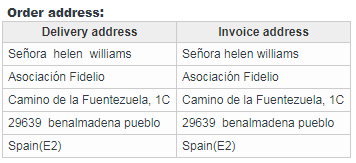

In [156]:
#Sending to Portugal (zipcode, Versandkosten > 10€)
ed_res_bv.loc[58442]

TC_ID                                                              6322356
O_ID_len                                                                 5
O_DATE_list              [2018-04-07 00:41:28, 2018-05-13 14:38:59, 201...
O_K_ID_list                                                      [7792339]
OSP_KO_COUNT_NET_list                                 [28, 29, 30, 31, 32]
O_K_COUNTER_MAX_list                                                  [32]
O_GWERT_sum                                                        1982.22
O_GWERT_list                      [561.09, 449.01, 314.64, 341.06, 316.42]
APS_AP_ID_list           [[57797, 64057, 68129, 50341, 67327, 15886, 75...
OP_AS_ID_len_list                                     [24, 18, 16, 12, 14]
OP_AS_ID_list            [[1160073, 1911183, 1840636, 2373807, 1951075,...
OP_AMOUNT_list           [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
LEAD_AS_ID                {1807303: 1, 1159997: 2, 2416926: 1, 2106475: 1}
L2_PG_ID                 

https://cc-admin.prod.zooplus.net/phpadmin/cc/customer/detail/cId-7792339

#### Outliers in items per order > 70%

In [157]:
ed_res_items = customers[(customers['ED'] == 1) & (customers['OUTL_ITEMS_%'] >= 0.7)] 

In [158]:
ed_res_items

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,APS_AP_ID_list,OP_AS_ID_len_list,...,OUTL_BASKET_VALUES,OUTL_ITEMS,OUTL_O_POS,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%,OUTLIER_SCORE,LT_RESELLERS,ED
7323,182540,10,"[2018-03-04 23:54:00, 2018-03-29 22:30:22, 201...",[5919147],"[107, 108, 109, 110, 111, 112, 113, 114, 115, ...",[116],1451.36,"[176.94, 129.57, 242.89, 194.4, 100.34, 162.16...","[[63030, 6169, 52416, 61236, 69052, 75236, 612...","[14, 11, 11, 9, 5, 10, 13, 2, 7, 14]",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 0, 1, 1, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0,0.0,0.700,0.0,1.0,0,1
42230,4614891,5,"[2018-03-15 00:52:46, 2018-05-14 19:21:21, 201...",[5551872],"[18, 19, 20, 21, 22]",[22],935.92,"[218.25, 202.03, 183.77, 141.21, 190.66]","[[64657, 27538, 73002, 68019, 59841, 68020, 61...","[48, 37, 29, 40, 62]",...,"[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]","[1, 1, 1, 1, 1]",0.0,0.0,1.000,1.0,2.0,0,1
97351,9337770,6,"[2018-03-29 08:38:11, 2018-05-03 09:49:17, 201...",[12231973],"[32, 33, 34, 35, 36, 37]",[37],815.97,"[156.1, 78.5, 91.97, 114.88, 184.21, 190.31]","[[68913, 20124, 69107, 58450, 32198, 50350, 64...","[14, 14, 16, 18, 14, 13]",...,"[0, 0, 0, 0, 0, 0]","[1, 1, 1, 0, 1, 1]","[0, 0, 0, 0, 0, 0]",0.0,0.0,0.833,0.0,1.0,0,1
134016,11528357,6,"[2018-03-13 23:36:51, 2018-04-11 15:54:04, 201...",[15538881],"[11, 12, 13, 14, 15, 16]",[16],1180.13,"[221.54, 181.41, 229.47, 171.85, 176.19, 199.67]","[[22185, 58539, 52416, 64625, 52417, 69043, 28...","[12, 10, 12, 13, 10, 11]",...,"[0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 0, 1]","[0, 0, 0, 0, 0, 0]",0.0,0.0,0.833,0.0,1.0,0,1


In [159]:
ed_res_items.loc[7323]

TC_ID                                                               182540
O_ID_len                                                                10
O_DATE_list              [2018-03-04 23:54:00, 2018-03-29 22:30:22, 201...
O_K_ID_list                                                      [5919147]
OSP_KO_COUNT_NET_list    [107, 108, 109, 110, 111, 112, 113, 114, 115, ...
O_K_COUNTER_MAX_list                                                 [116]
O_GWERT_sum                                                        1451.36
O_GWERT_list             [176.94, 129.57, 242.89, 194.4, 100.34, 162.16...
APS_AP_ID_list           [[63030, 6169, 52416, 61236, 69052, 75236, 612...
OP_AS_ID_len_list                     [14, 11, 11, 9, 5, 10, 13, 2, 7, 14]
OP_AS_ID_list            [[1461801, 1, 1038125, 1300895, 1902078, 22126...
OP_AMOUNT_list           [[4, 1, 16, 2, 6, 4, 2, 4, 2, 8, 6, 4, 8, 1], ...
LEAD_AS_ID               {1319614: 1, 1303383: 1, 2304584: 3, 1303107: ...
L2_PG_ID                 

https://cc-admin.prod.zooplus.net/phpadmin/cc/customer/detail/cId-5919147
<html><head>


<!-- Load require.js. Delete this if your page already loads require.js -->
<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.4/require.min.js" integrity="sha256-Ae2Vz/4ePdIu6ZyI/5ZGsYnb+m0JlOmKPjt6XZ9JJkA=" crossorigin="anonymous"></script>
<script src="https://unpkg.com/@jupyter-widgets/html-manager@*/dist/embed-amd.js" crossorigin="anonymous"></script>
<script type="application/vnd.jupyter.widget-state+json">
{
    "version_major": 2,
    "version_minor": 0,
    "state": {}
}
</script>
</head>
<body>


</body>
</html>
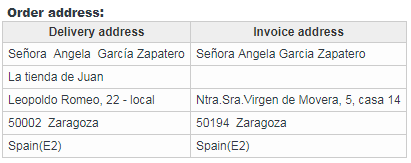

In [160]:
#Lot of snacks
ed_res_items.loc[97351]

TC_ID                                                              9337770
O_ID_len                                                                 6
O_DATE_list              [2018-03-29 08:38:11, 2018-05-03 09:49:17, 201...
O_K_ID_list                                                     [12231973]
OSP_KO_COUNT_NET_list                             [32, 33, 34, 35, 36, 37]
O_K_COUNTER_MAX_list                                                  [37]
O_GWERT_sum                                                         815.97
O_GWERT_list                  [156.1, 78.5, 91.97, 114.88, 184.21, 190.31]
APS_AP_ID_list           [[68913, 20124, 69107, 58450, 32198, 50350, 64...
OP_AS_ID_len_list                                 [14, 14, 16, 18, 14, 13]
OP_AS_ID_list            [[1871978, 1346517, 1902080, 2091317, 532642, ...
OP_AMOUNT_list           [[2, 1, 15, 5, 1, 10, 5, 1, 17, 1, 5, 2, 10, 1...
LEAD_AS_ID                             {1346517: 1, 532642: 4, 1352548: 1}
L2_PG_ID                 

https://cc-admin.prod.zooplus.net/phpadmin/cc/customer/detail/cId-12231973

### Check resellers list provided by SMA

In [161]:
resellers_checklist = pd.read_csv('Blacklist_Reseller.csv')

In [162]:
checklist_resellers = list(resellers_checklist['k_id'].values)

In [163]:
len(checklist_resellers)

267

In [164]:
customers.head()

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,APS_AP_ID_list,OP_AS_ID_len_list,...,OUTL_BASKET_VALUES,OUTL_ITEMS,OUTL_O_POS,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%,OUTLIER_SCORE,LT_RESELLERS,ED
0,7,1,[2018-04-23 16:55:48],[18926884],[2],[2],23.97,[23.97],"[[55500, 68384, 6168]]",[3],...,[0],[0],[0],0.00,0.0,0.0,0.0,0.0,0,0
1,119,2,"[2018-05-07 22:56:48, 2018-08-12 14:08:29]",[3430986],"[6, 7]",[7],59.94,"[29.97, 29.97]","[[70742, 6168], [70742, 6168]]","[2, 2]",...,"[0, 0]","[0, 0]","[0, 0]",0.00,0.0,0.0,0.0,0.0,0,0
2,144,1,[2018-09-14 17:17:32],[17546766],[4],[4],81.99,[81.99],[[57800]],[1],...,[0],[0],[0],0.00,0.0,0.0,0.0,0.0,0,0
3,146,2,"[2018-04-10 19:01:54, 2018-06-04 23:49:59]",[16330511],"[11, 12]",[12],120.56,"[49.37, 71.19]","[[23377, 62906, 42715], [27543, 68325, 62906, ...","[3, 5]",...,"[0, 0]","[0, 0]","[0, 0]",0.00,0.0,0.0,0.0,0.0,0,0
4,226,5,"[2018-05-12 09:56:23, 2018-05-23 12:32:57, 201...",[5652334],"[54, 55, 56, 57, 58]",[58],254.34,"[79.52, 28.23, 77.58, 40.78, 28.23]","[[28168, 68165, 42715], [25854, 9795, 9795, 25...","[3, 6, 3, 3, 3]",...,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",0.25,0.0,0.0,0.0,0.0,0,0


In [165]:
customers['K_ID_IN_CHECKLIST'] = [any([j in checklist_resellers for j in i]) * 1 for i in customers['O_K_ID_list'].values]

In [166]:
customers['K_ID_IN_CHECKLIST'].value_counts()

0    246638
1        13
Name: K_ID_IN_CHECKLIST, dtype: int64

13 true customer IDs matching with the IDs in the list provided...here they are.

In [167]:
customers[customers['K_ID_IN_CHECKLIST'] == 1]

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,APS_AP_ID_list,OP_AS_ID_len_list,...,OUTL_ITEMS,OUTL_O_POS,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%,OUTLIER_SCORE,LT_RESELLERS,ED,K_ID_IN_CHECKLIST
277,6254,1,[2018-05-22 14:03:26],[12014978],[616],[616],46.49,[46.49],"[[26599, 42715]]",[2],...,[0],[0],0.000,0.000,0.000,0.000,1.0,1,0,1
347,7799,1028,"[2018-03-01 07:05:07, 2018-03-01 07:36:35, 201...","[9476779, 16328933, 16495905, 17667361, 185337...","[55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 6...","[79, 4016, 4382, 3547, 550, 1]",95342.18,"[52.48, 55.79, 54.48, 55.27, 55.79, 52.48, 55....","[[70882, 6168, 42715], [68753, 42715], [24445,...","[3, 2, 3, 3, 2, 3, 2, 3, 4, 3, 2, 2, 3, 3, 2, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.993,0.020,0.001,0.000,6.0,1,0,1
1425,34434,154,"[2018-03-02 20:14:18, 2018-03-05 13:41:28, 201...","[9700383, 20112927]","[259, 260, 261, 262, 263, 264, 265, 266, 269, ...","[289, 123]",21789.76,"[166.69, 125.17, 89.35, 92.31, 106.85, 100.03,...","[[68396, 60996, 5482, 52564, 75090, 42715], [5...","[6, 8, 10, 4, 4, 3, 7, 3, 4, 4, 7, 5, 6, 4, 6,...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.889,0.019,0.006,0.000,5.0,1,0,1
9270,233995,37,"[2018-03-05 10:42:50, 2018-03-06 10:44:08, 201...",[3351945],"[176, 177, 178, 179, 180, 181, 182, 183, 184, ...",[212],11460.16,"[622.01, 100.54, 196.53, 224.26, 846.9, 515.83...","[[33151, 57311, 59815, 65427, 61079, 45955, 68...","[15, 3, 7, 12, 21, 19, 3, 25, 5, 5, 12, 2, 9, ...",...,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",0.361,0.405,0.054,0.027,5.0,1,0,1
11508,293046,26,"[2018-03-07 17:42:55, 2018-03-16 21:52:07, 201...",[1874575],"[240, 241, 242, 243, 244, 245, 246, 247, 248, ...",[265],6791.56,"[335.16, 205.55, 298.74, 245.18, 191.58, 293.3...","[[64678, 50230, 68137, 68685, 71475, 57799, 54...","[8, 7, 7, 11, 5, 11, 5, 5, 11, 13, 10, 12, 13,...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.080,0.462,0.000,0.000,4.0,1,0,1
12344,314497,44,"[2018-03-01 18:39:22, 2018-03-09 23:06:02, 201...",[2565850],"[334, 336, 337, 338, 339, 340, 342, 343, 345, ...",[386],10613.47,"[172.62, 100.99, 125.89, 40.36, 171.93, 117.2,...","[[71152, 55166, 67833, 68103, 67834, 76481, 98...","[17, 8, 11, 4, 14, 8, 13, 3, 14, 14, 7, 4, 10,...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.512,0.205,0.159,0.250,6.0,1,0,1
13953,359726,39,"[2018-03-06 11:47:39, 2018-03-07 18:28:45, 201...",[18895132],"[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 2...",[58],5299.21,"[169.02, 132.98, 71.18, 173.11, 132.98, 115.83...","[[69044, 68059, 73732, 73457, 42715], [69058, ...","[5, 3, 5, 4, 3, 6, 6, 6, 5, 9, 6, 8, 5, 4, 6, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.395,0.000,0.000,0.000,3.0,1,0,1
19045,492857,167,"[2018-03-01 14:18:03, 2018-03-01 14:27:32, 201...","[14908873, 15935516, 16233761, 16290515, 18526...","[11, 12, 13, 9, 10, 11, 12, 2690, 5, 6, 5, 8, ...","[13, 12, 2690, 6, 75, 2, 2, 2, 3, 253, 294, 3,...",13495.17,"[57.99, 58.99, 69.99, 84.36, 87.27, 39.76, 38....","[[61056], [80735], [69517], [77023, 42715], [7...","[1, 1, 1, 2, 2, 4, 2, 2, 4, 2, 3, 2, 2, 3, 2, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.928,0.000,0.000,0.000,6.0,1,0,1
56625,6156199,7,"[2018-03-09 18:01:42, 2018-07-08 22:25:24, 201...",[8576997],"[191, 202, 203, 205, 206, 208, 209]",[209],2074.22,"[69.99, 41.98, 377.94, 628.96, 69.99, 523.7, 3...","[[63217], [22220, 6168], [30682, 64028, 5482, ...","[1, 2, 4, 6, 1, 6, 11]",...,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",0.000,0.571,0.000

From the list provided let's extract from Oracle the registration site ID for those customer IDs...

In [168]:
res_list = repr(checklist_resellers).replace('[','(').replace(']',')')

In [169]:
query = """select k_id, k_registration_s_id from ZOOMAN.KUNDEN
where k_id in %s""" % res_list

In [170]:
conn = cx_Oracle.connect('zooor', 'zoo12or', 'zoorep', threaded=True, encoding = "UTF-8", nencoding = "UTF-8")
reseller_df = pd.read_sql(query, con = conn)
conn.close()

In [171]:
# Impressive Romania (site ID 24)
reseller_df['K_REGISTRATION_S_ID'].value_counts()

1      92
8      67
12     21
7      17
15     13
24     13
3      11
4       8
16      6
18      3
14      3
20      3
21      2
25      2
31      1
19      1
29      1
30      1
2       1
101     1
Name: K_REGISTRATION_S_ID, dtype: int64

### More restrictive approach to identify resellers

Remember 'outlier score' calculation: 

In case we want to deal with a smaller sample of customers we can became more restrictive and get only customers having an outlier score equal or greater than X. The greater the score, the higher number of features are requested to be outliers. 

- 'OUTL_ORDERS', 'OUTL_OCI_PLZ', 'OUTL_TOT_O_GWERT', 'OUTL_AS_IDs', 'OUTL_O_COUNTER' can be only 0 or 1
- 'OUTL\_TD\_%', 'OUTL\_BV\_%', 'OUTL\_ITEMS\_%', 'OUTL\_O\_POS\_%' are values between 0 and 1

score equal or greater than 3...which gives us a total amount of 159 customers

In [172]:
cus_score_over_3 = customers[customers['OUTLIER_SCORE'] >= 3]

In [173]:
cus_score_over_3[['O_ID_len', 'O_GWERT_sum', 'OUTL_TD_%']].describe().round(3)

,O_ID_len,O_GWERT_sum,OUTL_TD_%
count,159.000,159.000,159.000
mean,40.264,4346.164,0.323
std,89.663,7933.011,0.217
min,1.000,126.070,0.000
25%,23.000,2396.330,0.173
50%,29.000,3049.750,0.316
75%,37.000,4177.695,0.452
max,1028.000,95342.180,0.996


In [174]:
cus_score_over_3['LT_RESELLERS'].value_counts()

1    149
0     10
Name: LT_RESELLERS, dtype: int64

In [175]:
cus_score_over_3.sample(10)

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,APS_AP_ID_list,OP_AS_ID_len_list,...,OUTL_ITEMS,OUTL_O_POS,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%,OUTLIER_SCORE,LT_RESELLERS,ED,K_ID_IN_CHECKLIST
25272,2582306,24,"[2018-03-03 08:25:55, 2018-03-19 08:27:18, 201...",[2993518],"[156, 157, 158, 159, 160, 161, 162, 163, 164, ...",[179],1444.09,"[54.14, 57.57, 47.1, 47.23, 57.79, 38.94, 151....","[[28167, 25853, 39512, 25152, 39513, 42715], [...","[6, 7, 8, 4, 5, 7, 2, 6, 3, 6, 8, 5, 8, 6, 7, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.174,0.000,0.000,0.0,3.0,1,0,0
1430,34501,48,"[2018-03-02 10:34:10, 2018-03-06 11:29:13, 201...",[9963286],"[202, 203, 204, 205, 206, 207, 208, 209, 210, ...",[249],3284.15,"[104.7, 97.91, 42.65, 65.88, 65.9, 49.4, 42.66...","[[73732, 65202, 38522, 23044, 70842, 42715], [...","[6, 5, 3, 7, 5, 7, 3, 6, 6, 4, 4, 4, 8, 5, 6, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.447,0.000,0.000,0.0,4.0,1,0,0
33575,3571530,28,"[2018-03-06 11:36:18, 2018-03-19 16:26:15, 201...",[4186818],"[155, 156, 157, 158, 159, 160, 161, 162, 163, ...",[182],3870.41,"[130.18, 234.75, 186.04, 223.83, 63.02, 206.46...","[[63148, 6169, 68113, 32417, 32418, 42715], [7...","[6, 5, 10, 13, 4, 8, 3, 5, 8, 10, 9, 12, 14, 9...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.222,0.071,0.000,0.0,4.0,1,0,0
12816,329847,25,"[2018-03-22 15:22:53, 2018-04-01 02:09:41, 201...",[3340473],"[118, 119, 120, 121, 122, 123, 124, 125, 126, ...",[145],3480.66,"[213.22, 140.8, 224.0, 75.57, 134.95, 238.35, ...","[[1440, 68059, 50230, 52637, 19588, 5482, 1439...","[7, 14, 3, 4, 3, 3, 4, 4, 6, 6, 3, 4, 6, 5, 3,...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.167,0.040,0.040,0.0,3.0,1,0,0
12062,306882,25,"[2018-03-01 12:05:05, 2018-03-06 10:21:04, 201...",[14950616],"[37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 4...",[61],3691.26,"[177.39, 93.1, 112.42, 124.06, 186.12, 179.83,...","[[63031, 50339, 50336, 56959, 50335, 50302, 56...","[9, 4, 11, 11, 9, 8, 11, 2, 9, 8, 15, 11, 7, 1...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.042,0.000,0.040,0.0,3.0,1,0,0
20084,1673632,8,"[2018-03-13 14:29:58, 2018-03-25 20:01:19, 201...",[1830425],"[164, 165, 166, 167, 168, 169, 170, 171]",[171],2849.66,"[97.96, 422.23, 199.92, 320.38, 253.89, 985.65...","[[32585, 6169], [64656, 6169, 57455, 52637, 50...","[2, 11, 4, 7, 4, 20, 5, 4]",...,"[0, 0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]",0.000,0.625,0.125,0.0,3.0,1,0,0
50683,5595673,1,[2018-03-25 20:50:47],[6830465],[62],[62],437.20,[437.2],"[[32485, 65464, 6169, 65466, 28024, 25854, 646...",[29],...,[1],[1],0.000,1.000,1.000,1.0,3.0,0,0,0
3992,93646,31,"[2018-03-07 13:06:47, 2018-03-09 13:18:32, 201...","[4316610, 4717272, 7619957, 12197768]","[52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 9...","[62, 114, 57, 19]",5198.12,"[40.96, 160.93, 87.96, 55.97, 56.98, 101.95, 5...","[[64121, 5592, 67399, 44724], [44438, 61197, 6...","[4, 5, 4, 2, 2, 4, 2, 3, 6, 4, 2, 9, 5, 11, 8,...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.433,0.226,0.000,0.0,6.0,1,0,0
9868,246471,33,"[2018-03-06 12:30:25, 2018-03-14 10:57:40, 201...",[2537279],"[258, 259, 260, 261, 262, 263, 264, 265, 266, ...",[290],2800.84,"[115.56, 52.8, 49.0, 47.09, 49.36, 102.44, 102...","[[61225, 75031, 69003, 55166, 65587, 58756, 63...","[10, 6, 3, 4, 5, 9, 12, 7, 11, 6, 10, 7, 8, 10...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.250,0.000,0.000,0.0,4.0,1,0,0
17186,441445,31,"[2018-03-12 11:10:22, 2018-03-20 05:04:45, 201...",[3480262],"[102, 1

If we choose 4 as the score threshold...65 true customers would be the result

In [176]:
cus_score_over_4 = customers[customers['OUTLIER_SCORE'] >= 4]

In [177]:
cus_score_over_4[['O_ID_len', 'O_GWERT_sum', 'OUTL_TD_%']].describe().round(3)

,O_ID_len,O_GWERT_sum,OUTL_TD_%
count,65.000,65.000,65.000
mean,65.385,6825.306,0.466
std,136.281,11916.252,0.197
min,7.000,1792.700,0.080
25%,30.000,3070.610,0.341
50%,36.000,3843.730,0.447
75%,48.000,6047.650,0.556
max,1028.000,95342.180,0.996


In [178]:
cus_score_over_4['LT_RESELLERS'].value_counts()

1    65
Name: LT_RESELLERS, dtype: int64

In [179]:
cus_score_over_4.sample(10)

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,APS_AP_ID_list,OP_AS_ID_len_list,...,OUTL_ITEMS,OUTL_O_POS,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%,OUTLIER_SCORE,LT_RESELLERS,ED,K_ID_IN_CHECKLIST
1219,29558,54,"[2018-03-06 20:23:37, 2018-04-05 12:40:37, 201...",[12890111],"[1570, 1611, 1617, 1618, 1619, 1620, 1621, 162...",[1907],5909.38,"[121.98, 22.98, 102.98, 22.98, 169.48, 102.98,...","[[71861, 42715, 6168], [6168, 48259, 42715], [...","[3, 3, 3, 4, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.604,0.000,0.000,0.000,5.0,1,0,0
19230,1427830,22,"[2018-03-06 20:39:45, 2018-03-09 12:16:31, 201...","[1987573, 9596636]","[169, 170, 171, 172, 173, 174, 175, 176, 177, ...","[186, 37]",1792.70,"[111.06, 86.79, 124.21, 137.16, 50.46, 78.19, ...","[[67412, 73409, 5482, 64678, 52570, 50861, 512...","[10, 7, 9, 15, 4, 13, 8, 6, 12, 6, 6, 8, 6, 5,...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.286,0.000,0.000,0.000,4.0,1,0,0
33575,3571530,28,"[2018-03-06 11:36:18, 2018-03-19 16:26:15, 201...",[4186818],"[155, 156, 157, 158, 159, 160, 161, 162, 163, ...",[182],3870.41,"[130.18, 234.75, 186.04, 223.83, 63.02, 206.46...","[[63148, 6169, 68113, 32417, 32418, 42715], [7...","[6, 5, 10, 13, 4, 8, 3, 5, 8, 10, 9, 12, 14, 9...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.222,0.071,0.000,0.000,4.0,1,0,0
4185,98611,33,"[2018-03-01 17:20:28, 2018-03-08 01:32:51, 201...",[17722191],"[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 2...",[50],2470.78,"[70.75, 92.56, 81.43, 60.05, 69.09, 72.22, 74....","[[38423, 65201, 71144, 62497, 1538, 42715], [7...","[6, 9, 6, 12, 10, 6, 8, 13, 9, 12, 14, 6, 8, 6...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.406,0.000,0.000,0.000,4.0,1,0,0
1239,30101,59,"[2018-03-05 11:51:44, 2018-03-09 12:46:53, 201...",[13009491],"[100, 101, 102, 103, 104, 105, 106, 107, 108, ...",[158],8872.15,"[205.03, 191.82, 93.98, 157.61, 147.2, 232.65,...","[[64056, 61295, 64618, 61247, 64105, 67027, 61...","[10, 14, 8, 10, 7, 11, 11, 5, 17, 6, 15, 3, 6,...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.552,0.068,0.000,0.000,5.0,1,0,0
8482,212091,81,"[2018-03-02 19:22:27, 2018-03-03 15:09:23, 201...",[10205152],"[79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 9...",[159],7368.39,"[59.14, 46.55, 53.32, 38.27, 118.32, 83.87, 10...","[[42715, 67400, 67363], [57452, 42715], [42715...","[3, 2, 4, 5, 3, 5, 3, 2, 3, 5, 3, 3, 3, 7, 3, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.762,0.037,0.000,0.012,5.0,1,0,0
14293,371068,24,"[2018-03-02 22:21:28, 2018-03-11 21:58:04, 201...","[1245283, 1261197, 2732437, 3169792]","[159, 160, 161, 162, 163, 164, 165, 166, 167, ...","[169, 48, 18, 22]",3192.91,"[255.45, 89.95, 148.41, 82.75, 124.14, 140.94,...","[[60981, 22185, 27104, 70895, 67025, 5482, 611...","[11, 3, 7, 4, 4, 8, 4, 8, 7, 4, 2, 4, 5, 2, 1,...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.348,0.042,0.000,0.000,5.0,1,0,0
7304,182118,33,"[2018-03-04 15:04:01, 2018-03-06 19:50:59, 201...","[3544893, 16834681]","[115, 116, 117, 118, 119, 120, 121, 122, 123, ...","[145, 3]",5543.27,"[129.4, 110.98, 110.98, 340.34, 166.44, 162.66...","[[25387, 2502, 10889, 50341, 52768, 61348, 108...","[10, 7, 6, 13, 9, 9, 14, 8, 7, 7, 6, 3, 6, 11,...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.344,0.152,0.030,0.030,4.0,1,0,0
16356,420644,36,"[2018-03-01 20:26:25, 2018-03-07 19:45:28, 201...",[14467485],"[54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 6..

### Save as pickle file

In [180]:
#customers.to_pickle('./outlier_detection_in_customer_behavior_es.pkl')

In [181]:
#customers = pd.read_pickle('./outlier_detection_in_customer_behavior_es.pkl')

In [182]:
customers['OCI_PLZ_len'] = customers['OCI_PLZ_list'].apply(len)

In [183]:
customers['LEAD_AS_ID_len'] = customers['LEAD_AS_ID'].apply(len)

In [184]:
customers['MAX_O_COUNTER'] = customers['O_K_COUNTER_MAX_list'].apply(sum)

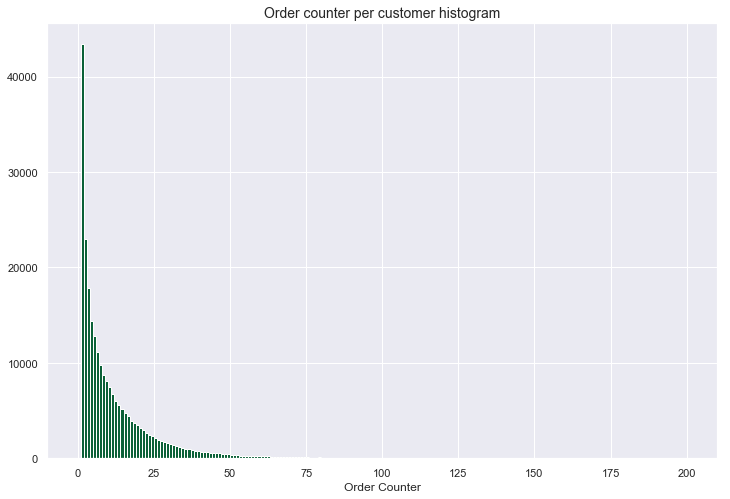

In [185]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(customers['MAX_O_COUNTER'], bins=200, range=(0, 200), color='#0B6138')
plt.xlabel('Order Counter')
plt.title('Order counter per customer histogram', fontsize=14)
plt.show()

In [186]:
Counter(customers['MAX_O_COUNTER'].values), np.percentile(customers['MAX_O_COUNTER'].values, 99.99)

(Counter({1: 43398,
          2: 22931,
          3: 17798,
          4: 14429,
          5: 12763,
          6: 11119,
          7: 9816,
          8: 8733,
          9: 8149,
          10: 7449,
          11: 6767,
          12: 5987,
          13: 5617,
          14: 5149,
          15: 4727,
          16: 4442,
          17: 3940,
          18: 3749,
          19: 3445,
          20: 3135,
          21: 2928,
          22: 2695,
          23: 2442,
          24: 2330,
          25: 2133,
          26: 1933,
          27: 1804,
          28: 1732,
          29: 1571,
          30: 1450,
          31: 1348,
          32: 1317,
          33: 1165,
          34: 1048,
          35: 993,
          36: 969,
          37: 844,
          38: 805,
          39: 777,
          40: 703,
          41: 658,
          42: 611,
          43: 563,
          44: 548,
          45: 516,
          46: 512,
          47: 434,
          48: 446,
          49: 426,
          50: 351,
          51: 343,


### Comparison with other reseller logics in the company - adaption-

In [187]:
cus_score_over_4 = customers[customers['OUTLIER_SCORE'] >= 4]

#### Großkundenanalyse (big customers analysis) from Anna

+ 10.000€ last 12 months
+ 1.000€ last 4 weeks on tcs level

As we have 6 months data we will look for these TC having spent more than 5000€

In [188]:
grosskunden = customers[customers['O_GWERT_sum'] >= 5000]

In [189]:
grosskunden

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,APS_AP_ID_list,OP_AS_ID_len_list,...,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%,OUTLIER_SCORE,LT_RESELLERS,ED,K_ID_IN_CHECKLIST,OCI_PLZ_len,LEAD_AS_ID_len,MAX_O_COUNTER
347,7799,1028,"[2018-03-01 07:05:07, 2018-03-01 07:36:35, 201...","[9476779, 16328933, 16495905, 17667361, 185337...","[55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 6...","[79, 4016, 4382, 3547, 550, 1]",95342.18,"[52.48, 55.79, 54.48, 55.27, 55.79, 52.48, 55....","[[70882, 6168, 42715], [68753, 42715], [24445,...","[3, 2, 3, 3, 2, 3, 2, 3, 4, 3, 2, 2, 3, 3, 2, ...",...,0.020,0.001,0.000,6.0,1,0,1,788,98,12575
1009,24196,8,"[2018-03-26 17:51:31, 2018-04-11 19:08:25, 201...",[8245091],"[109, 110, 111, 112, 113, 114, 115, 116]",[116],5494.05,"[919.58, 931.79, 740.88, 869.23, 143.97, 563.4...","[[57798, 14444, 28168, 55406, 26186, 57804, 75...","[29, 17, 19, 20, 5, 14, 17, 20]",...,0.875,0.000,0.125,2.0,1,0,0,1,5,116
1219,29558,54,"[2018-03-06 20:23:37, 2018-04-05 12:40:37, 201...",[12890111],"[1570, 1611, 1617, 1618, 1619, 1620, 1621, 162...",[1907],5909.38,"[121.98, 22.98, 102.98, 22.98, 169.48, 102.98,...","[[71861, 42715, 6168], [6168, 48259, 42715], [...","[3, 3, 3, 4, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, ...",...,0.000,0.000,0.000,5.0,1,0,0,53,12,1907
1239,30101,59,"[2018-03-05 11:51:44, 2018-03-09 12:46:53, 201...",[13009491],"[100, 101, 102, 103, 104, 105, 106, 107, 108, ...",[158],8872.15,"[205.03, 191.82, 93.98, 157.61, 147.2, 232.65,...","[[64056, 61295, 64618, 61247, 64105, 67027, 61...","[10, 14, 8, 10, 7, 11, 11, 5, 17, 6, 15, 3, 6,...",...,0.068,0.000,0.000,5.0,1,0,0,1,34,158
1359,32780,22,"[2018-03-12 13:59:09, 2018-04-11 20:05:01, 201...",[9289266],"[150, 150, 151, 152, 153, 154, 155, 156, 157, ...",[170],5442.57,"[610.72, 474.79, 187.99, 197.5, 170.91, 250.67...","[[64738, 50340, 64798, 50341, 52637, 71887, 50...","[10, 6, 5, 6, 4, 7, 2, 2, 2, 8, 6, 3, 7, 4, 6,...",...,0.318,0.045,0.000,4.0,1,0,0,1,13,170
1425,34434,154,"[2018-03-02 20:14:18, 2018-03-05 13:41:28, 201...","[9700383, 20112927]","[259, 260, 261, 262, 263, 264, 265, 266, 269, ...","[289, 123]",21789.76,"[166.69, 125.17, 89.35, 92.31, 106.85, 100.03,...","[[68396, 60996, 5482, 52564, 75090, 42715], [5...","[6, 8, 10, 4, 4, 3, 7, 3, 4, 4, 7, 5, 6, 4, 6,...",...,0.019,0.006,0.000,5.0,1,0,1,2,64,412
1677,40523,19,"[2018-03-04 19:54:11, 2018-03-26 21:43:33, 201...",[1942017],"[175, 176, 177, 178, 179, 180, 181, 182, 183, ...",[193],6493.83,"[592.9, 376.99, 610.9, 312.17, 224.91, 385.99,...","[[68059, 50230, 5482, 67426, 61197], [67426, 6...","[5, 5, 5, 5, 2, 4, 4, 3, 4, 3, 5, 5, 2, 5, 1, ...",...,0.684,0.000,0.000,3.0,1,0,0,1,6,193
3120,72173,44,"[2018-03-05 12:45:25, 2018-03-05 13:41:17, 201...",[8007843],"[243, 244, 245, 246, 247, 248, 249, 250, 251, ...",[286],5229.55,"[104.24, 101.45, 116.35, 104.68, 109.36, 121.0...","[[61246, 6169, 61248, 42715], [61213, 52642, 6...","[4, 4, 4, 6, 5, 3, 4, 4, 3, 2, 5, 3, 4, 3, 1, ...",...,0.000,0.000,0.000,4.0,1,0,0,2,28,286
3133,72439,81,"[2018-03-04 18:37:12, 2018-03-06 11:21:15, 201...","[1520727, 1911853, 2012327, 3369365, 3491162, ...","[62, 63, 64, 65, 66, 67, 39, 40, 54, 55, 56, 6...","[67, 40, 56, 69, 38, 13, 45, 1030, 47, 59, 28,...",18345.54,"[114.65, 69.29, 109.48, 74.97, 115.88, 114.98,...","[[6169, 57809], [69771, 67299, 6169], [6169, 5...","[2, 3, 4, 4, 4, 4, 2, 3, 4, 5, 3, 5, 2, 3, 3, ...",...,0.123,0.099,0.000,6.0,1,0,0,30,59,1612
3386,78376,87,"[2018-03-03 12:18:33, 2018-03-12 16:27:41, 201...",[17782264],"[67, 68, 69, 70, 72, 72, 73, 74, 76, 76, 77, 7...",[160],6582.60,"[56.99, 52.24, 52.24, 80.74, 64.58, 100.64, 56...","[[70351, 42715], [70441, 42715], [70441, 42715...","[2, 2, 2, 2, 3, 6, 2, 2, 3, 5, 2, 3, 2, 4, 2, ...",...,0.011,0.000,0.000,6.0,1,0,0,60,48,160


In [190]:
grosskunden['OUTLIER_SCORE'].value_counts()

4.0    11
5.0     7
6.0     7
3.0     6
2.0     5
Name: OUTLIER_SCORE, dtype: int64

In [191]:
grosskunden.loc[1009]

TC_ID                                                                24196
O_ID_len                                                                 8
O_DATE_list              [2018-03-26 17:51:31, 2018-04-11 19:08:25, 201...
O_K_ID_list                                                      [8245091]
OSP_KO_COUNT_NET_list             [109, 110, 111, 112, 113, 114, 115, 116]
O_K_COUNTER_MAX_list                                                 [116]
O_GWERT_sum                                                        5494.05
O_GWERT_list             [919.58, 931.79, 740.88, 869.23, 143.97, 563.4...
APS_AP_ID_list           [[57798, 14444, 28168, 55406, 26186, 57804, 75...
OP_AS_ID_len_list                          [29, 17, 19, 20, 5, 14, 17, 20]
OP_AS_ID_list            [[1159966, 1060560, 1724767, 1507941, 1054253,...
OP_AMOUNT_list           [[1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
LEAD_AS_ID               {1880203: 3, 1601428: 2, 534411: 1, 2030710: 1...
L2_PG_ID                 

#### ICV: 100 orders within last 24 months on TCS level 

Orders >= 25 for our 6 months time window

In [192]:
icv = customers[customers['O_ID_len'] >= 25]

In [193]:
icv

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,APS_AP_ID_list,OP_AS_ID_len_list,...,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%,OUTLIER_SCORE,LT_RESELLERS,ED,K_ID_IN_CHECKLIST,OCI_PLZ_len,LEAD_AS_ID_len,MAX_O_COUNTER
150,3454,56,"[2018-03-01 19:25:57, 2018-03-01 19:38:11, 201...",[15612650],"[75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 8...",[130],3656.80,"[126.7, 60.73, 143.36, 49.34, 78.84, 56.99, 48...","[[38430, 75614, 67611, 33963, 68036, 60577, 73...","[12, 8, 12, 8, 4, 4, 6, 2, 6, 6, 5, 5, 4, 6, 7...",...,0.000,0.000,0.000,4.0,1,0,0,2,41,130
264,5807,39,"[2018-03-05 20:25:26, 2018-03-08 13:48:35, 201...",[1613142],"[639, 640, 641, 642, 643, 644, 645, 646, 647, ...",[677],2864.11,"[94.07, 61.64, 50.33, 103.02, 68.95, 55.88, 12...","[[73340, 48236, 6169, 76041, 35908, 27104, 427...","[7, 9, 3, 6, 5, 8, 8, 7, 4, 5, 5, 3, 10, 5, 4,...",...,0.000,0.000,0.000,4.0,1,0,0,1,25,677
347,7799,1028,"[2018-03-01 07:05:07, 2018-03-01 07:36:35, 201...","[9476779, 16328933, 16495905, 17667361, 185337...","[55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 6...","[79, 4016, 4382, 3547, 550, 1]",95342.18,"[52.48, 55.79, 54.48, 55.27, 55.79, 52.48, 55....","[[70882, 6168, 42715], [68753, 42715], [24445,...","[3, 2, 3, 3, 2, 3, 2, 3, 4, 3, 2, 2, 3, 3, 2, ...",...,0.020,0.001,0.000,6.0,1,0,1,788,98,12575
477,10787,41,"[2018-03-04 02:44:58, 2018-03-08 14:47:57, 201...",[7210487],"[171, 172, 173, 174, 175, 176, 177, 178, 179, ...",[211],2701.22,"[44.41, 100.13, 98.12, 42.18, 57.38, 108.56, 4...","[[64056, 68204, 57485, 50341, 30629, 61348, 61...","[9, 9, 6, 5, 6, 9, 6, 5, 5, 5, 8, 6, 7, 7, 7, ...",...,0.000,0.000,0.000,4.0,1,0,0,1,24,211
580,13652,28,"[2018-04-09 08:48:35, 2018-04-09 09:18:44, 201...",[2791530],"[78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 8...",[105],1563.52,"[86.74, 85.79, 39.75, 50.83, 36.56, 63.59, 43....","[[72265, 67737, 60987, 61247, 72929, 64677, 73...","[8, 6, 3, 4, 4, 6, 2, 6, 5, 5, 10, 7, 7, 3, 2,...",...,0.000,0.000,0.000,3.0,1,0,0,3,21,105
993,23900,29,"[2018-03-02 11:51:11, 2018-03-13 20:26:45, 201...",[14384490],"[70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 8...",[98],2153.04,"[74.24, 44.48, 70.83, 64.98, 79.94, 77.97, 40....","[[50342, 33765, 61126, 68059, 15937, 72394, 52...","[7, 2, 6, 2, 7, 3, 1, 5, 1, 8, 5, 1, 3, 4, 5, ...",...,0.000,0.000,0.000,2.0,1,0,0,1,16,98
1188,28809,25,"[2018-03-01 10:42:37, 2018-03-13 10:56:55, 201...",[17412127],"[22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 3...",[46],1831.82,"[74.48, 68.42, 59.84, 88.44, 87.23, 86.67, 53....","[[61172, 61155, 30306, 34631, 6169, 839, 42715...","[8, 5, 7, 8, 7, 4, 7, 6, 8, 6, 6, 6, 7, 8, 7, ...",...,0.000,0.000,0.000,1.0,1,0,0,1,12,46
1219,29558,54,"[2018-03-06 20:23:37, 2018-04-05 12:40:37, 201...",[12890111],"[1570, 1611, 1617, 1618, 1619, 1620, 1621, 162...",[1907],5909.38,"[121.98, 22.98, 102.98, 22.98, 169.48, 102.98,...","[[71861, 42715, 6168], [6168, 48259, 42715], [...","[3, 3, 3, 4, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, ...",...,0.000,0.000,0.000,5.0,1,0,0,53,12,1907
1239,30101,59,"[2018-03-05 11:51:44, 2018-03-09 12:46:53, 201...",[13009491],"[100, 101, 102, 103, 104, 105, 106, 107, 108, ...",[158],8872.15,"[205.03, 191.82, 93.98, 157.61, 147.2, 232.65,...","[[64056, 61295, 64618, 61247, 64105, 67027, 61...","[10, 14, 8, 10, 7, 11, 11, 5, 17, 6, 15, 3, 6,...",...,0.068,0.000,0.000,5.0,1,0,0,1,34,158
1265,30534,38,"[2018-03-01 18:43:21, 2018-03-13 10:16:37, 201...",[15704359],"[35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 4...",[72],2227.38,"[50.41, 61.55, 74.68, 65.94, 47.5, 58.19, 89.1...","[[64364, 68471, 56866, 42715], [50337, 65558, ...","[4, 4, 2, 3, 3, 2, 5, 4, 4, 2, 4, 4, 5, 3, 3, ...",...,0.000,0.000,0.000,2.0,1,0,0,1,26,72


In [194]:
icv['OUTLIER_SCORE'].value_counts()

3.0    49
4.0    37
2.0    31
5.0    14
1.0    13
6.0     8
Name: OUTLIER_SCORE, dtype: int64

#### Comparison

In [195]:
cus_score_over_4[['O_ID_len', 'O_GWERT_sum', 'MAX_O_COUNTER', 'OCI_PLZ_len', 'LEAD_AS_ID_len',
                  'OUTL_TD_%', 'OUTL_BV_%', 'OUTL_ITEMS_%', 'OUTL_O_POS_%']].describe().round(2)

,O_ID_len,O_GWERT_sum,MAX_O_COUNTER,OCI_PLZ_len,LEAD_AS_ID_len,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%
count,65.00,65.00,65.00,65.00,65.00,65.00,65.00,65.00,65.00
mean,65.38,6825.31,492.89,24.49,28.62,0.47,0.10,0.02,0.02
std,136.28,11916.25,1598.82,108.26,19.34,0.20,0.17,0.09,0.10
min,7.00,1792.70,35.00,1.00,6.00,0.08,0.00,0.00,0.00
25%,30.00,3070.61,128.00,1.00,19.00,0.34,0.00,0.00,0.00
50%,36.00,3843.73,178.00,2.00,23.00,0.45,0.02,0.00,0.00
75%,48.00,6047.65,286.00,4.00,29.00,0.56,0.11,0.00,0.00
max,1028.00,95342.18,12575.00,788.00,127.00,1.00,0.86,0.71,0.71


In [196]:
grosskunden[['O_ID_len', 'O_GWERT_sum', 'MAX_O_COUNTER', 'OCI_PLZ_len', 'LEAD_AS_ID_len',
                  'OUTL_TD_%', 'OUTL_BV_%', 'OUTL_ITEMS_%', 'OUTL_O_POS_%']].describe().round(2)

,O_ID_len,O_GWERT_sum,MAX_O_COUNTER,OCI_PLZ_len,LEAD_AS_ID_len,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%
count,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00
mean,84.78,10443.64,688.42,41.58,30.67,0.43,0.25,0.03,0.02
std,181.70,15211.09,2138.04,144.06,25.81,0.27,0.26,0.06,0.05
min,8.00,5053.24,43.00,1.00,5.00,0.00,0.00,0.00,0.00
25%,26.75,5352.91,95.00,1.00,13.00,0.25,0.03,0.00,0.00
50%,36.00,6105.12,153.00,1.00,22.00,0.40,0.19,0.00,0.00
75%,54.25,8928.54,255.25,3.25,34.50,0.56,0.36,0.05,0.00
max,1028.00,95342.18,12575.00,788.00,127.00,1.00,0.88,0.29,0.25


In [197]:
icv[['O_ID_len', 'O_GWERT_sum', 'MAX_O_COUNTER', 'OCI_PLZ_len', 'LEAD_AS_ID_len',
                  'OUTL_TD_%', 'OUTL_BV_%', 'OUTL_ITEMS_%', 'OUTL_O_POS_%']].describe().round(2)

,O_ID_len,O_GWERT_sum,MAX_O_COUNTER,OCI_PLZ_len,LEAD_AS_ID_len,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%
count,152.00,152.00,152.00,152.00,152.00,152.00,152.00,152.00,152.00
mean,45.29,4350.96,274.72,11.24,22.49,0.35,0.04,0.01,0.01
std,90.47,8086.73,1059.17,71.41,14.33,0.20,0.10,0.03,0.03
min,25.00,974.09,27.00,1.00,6.00,0.00,0.00,0.00,0.00
25%,27.00,2138.05,78.00,1.00,15.75,0.21,0.00,0.00,0.00
50%,31.00,2856.28,124.50,1.00,20.00,0.33,0.00,0.00,0.00
75%,38.00,3880.57,190.25,2.00,24.00,0.45,0.03,0.00,0.00
max,1028.00,95342.18,12575.00,788.00,127.00,1.00,0.60,0.16,0.25


In [198]:
customers['OUTL_ORDERS'].value_counts()

0    246424
1       227
Name: OUTL_ORDERS, dtype: int64

In [199]:
customers['OUTL_TOT_O_GWERT'].value_counts()

0    246404
1       247
Name: OUTL_TOT_O_GWERT, dtype: int64

In [200]:
customers['OUTL_O_COUNTER'].value_counts()

0    246404
1       247
Name: OUTL_O_COUNTER, dtype: int64

In [201]:
customers[customers['OUTL_O_COUNTER'] == 1]

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,APS_AP_ID_list,OP_AS_ID_len_list,...,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%,OUTLIER_SCORE,LT_RESELLERS,ED,K_ID_IN_CHECKLIST,OCI_PLZ_len,LEAD_AS_ID_len,MAX_O_COUNTER
177,3934,4,"[2018-03-12 00:32:43, 2018-03-26 01:20:14, 201...","[1076041, 9816630]","[144, 134, 136, 137]","[144, 137]",453.04,"[218.21, 95.37, 51.73, 87.73]","[[71127, 78403, 60373, 78354, 6169, 71081, 710...","[15, 6, 3, 3]",...,0.000,0.000,0.000,1.0,1,0,0,2,4,281
264,5807,39,"[2018-03-05 20:25:26, 2018-03-08 13:48:35, 201...",[1613142],"[639, 640, 641, 642, 643, 644, 645, 646, 647, ...",[677],2864.11,"[94.07, 61.64, 50.33, 103.02, 68.95, 55.88, 12...","[[73340, 48236, 6169, 76041, 35908, 27104, 427...","[7, 9, 3, 6, 5, 8, 8, 7, 4, 5, 5, 3, 10, 5, 4,...",...,0.000,0.000,0.000,4.0,1,0,0,1,25,677
277,6254,1,[2018-05-22 14:03:26],[12014978],[616],[616],46.49,[46.49],"[[26599, 42715]]",[2],...,0.000,0.000,0.000,1.0,1,0,1,1,1,616
347,7799,1028,"[2018-03-01 07:05:07, 2018-03-01 07:36:35, 201...","[9476779, 16328933, 16495905, 17667361, 185337...","[55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 6...","[79, 4016, 4382, 3547, 550, 1]",95342.18,"[52.48, 55.79, 54.48, 55.27, 55.79, 52.48, 55....","[[70882, 6168, 42715], [68753, 42715], [24445,...","[3, 2, 3, 3, 2, 3, 2, 3, 4, 3, 2, 2, 3, 3, 2, ...",...,0.020,0.001,0.000,6.0,1,0,1,788,98,12575
477,10787,41,"[2018-03-04 02:44:58, 2018-03-08 14:47:57, 201...",[7210487],"[171, 172, 173, 174, 175, 176, 177, 178, 179, ...",[211],2701.22,"[44.41, 100.13, 98.12, 42.18, 57.38, 108.56, 4...","[[64056, 68204, 57485, 50341, 30629, 61348, 61...","[9, 9, 6, 5, 6, 9, 6, 5, 5, 5, 8, 6, 7, 7, 7, ...",...,0.000,0.000,0.000,4.0,1,0,0,1,24,211
502,11550,11,"[2018-04-06 12:22:42, 2018-05-07 10:54:19, 201...",[3394958],"[327, 328, 329, 330, 331, 332, 333, 336, 335, ...",[337],611.15,"[44.6, 44.57, 39.72, 58.19, 42.66, 58.19, 49.4...","[[45918, 56512, 42715], [42715, 45955, 60594, ...","[3, 5, 5, 2, 3, 2, 5, 3, 2, 4, 4]",...,0.000,0.000,0.000,1.0,1,0,0,2,10,337
575,13563,2,"[2018-03-30 09:55:15, 2018-04-17 08:38:23]",[17668463],"[890, 954]",[954],94.03,"[43.69, 50.34]","[[61072, 42715], [47716, 42715]]","[2, 2]",...,0.000,0.000,0.000,1.0,1,0,0,2,2,954
671,15661,1,[2018-06-07 23:29:12],[10282206],[4721],[4721],89.99,[89.99],[[55854]],[1],...,0.000,0.000,0.000,1.0,1,0,0,1,1,4721
784,18424,17,"[2018-03-12 11:32:37, 2018-03-17 16:14:42, 201...",[3571514],"[161, 162, 163, 164, 165, 166, 167, 168, 169, ...",[177],996.34,"[86.11, 59.54, 52.12, 38.92, 78.51, 65.5, 46.5...","[[60986, 61194, 58143, 60800, 42715], [68059, ...","[5, 4, 6, 3, 8, 8, 3, 4, 5, 8, 4, 6, 6, 6, 7, ...",...,0.000,0.000,0.000,1.0,1,0,0,3,13,177
801,18690,4,"[2018-08-11 16:27:11, 2018-08-20 18:26:08, 201...",[5192250],"[160, 163, 163, 167]",[167],795.33,"[162.45, 194.97, 127.59, 310.32]","[[14306, 58609, 54608, 25247, 63245, 73185, 58...","[15, 13, 13, 18]",...,0.250,0.000,0.000,1.0,1,0,0,1,4,167


In [202]:
customers['OUTL_O_COUNTER'].value_counts()

0    246404
1       247
Name: OUTL_O_COUNTER, dtype: int64

In [203]:
customers['OUTL_AS_IDs'].value_counts()

0    246405
1       246
Name: OUTL_AS_IDs, dtype: int64

In [204]:
customers[customers['OUTLIER_SCORE'] >= 4]['O_GWERT_sum'].sum()

443644.92000000004

In [205]:
customers.loc[347]['OCI_PLZ_list']

Counter({'00012': 1,
         '00030': 1,
         '00049': 1,
         '00055': 1,
         '00066': 1,
         '00123': 1,
         '00139': 1,
         '00141': 1,
         '00143': 1,
         '00174': 1,
         '01099': 1,
         '01127': 1,
         '01445': 2,
         '01705': 1,
         '01737': 1,
         '01744': 1,
         '01920': 1,
         '02708': 1,
         '02747': 1,
         '02906': 1,
         '02977': 2,
         '03116': 1,
         '03177': 1,
         '04299': 1,
         '04442': 1,
         '04523': 1,
         '04552': 1,
         '04828': 1,
         '06134': 1,
         '06179': 1,
         '06268': 1,
         '06295': 1,
         '06618': 3,
         '06785': 2,
         '07020': 1,
         '07026': 1,
         '07108': 1,
         '07157': 1,
         '07181': 1,
         '07407': 1,
         '07422': 1,
         '07580': 1,
         '07590': 3,
         '07660': 2,
         '07987': 1,
         '08003': 1,
         '08064': 1,
         '084